In [1]:
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 200)
import numpy as np

import math

import psycopg2
import sqlalchemy
import pickle
import matplotlib
import matplotlib.pyplot as plt
import re

from sklearn import preprocessing
from sklearn import datasets, linear_model, metrics 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error

import matplotlib.cm as cm

import seaborn as sns

# Data preparation

## Data collection AUTOTRADER

In [281]:
from sqlalchemy import create_engine
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'localhost' ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES USERNAME
POSTGRES_PASSWORD = 'password' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD POSTGRES_DBNAME = 'database' ## CHANGE THIS TO YOUR DATABASE NAME
#POSTGRES_DBNAME = 'ads_autotrader' 
POSTGRES_DBNAME = 'autotrader_motorbikes' 

# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, 
                                                                                        password=POSTGRES_PASSWORD,
                                                                                        ipaddress=POSTGRES_ADDRESS,
                                                                                        port=POSTGRES_PORT,
                                                                                        dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)
data_autotrader = pd.read_sql_query('''SELECT * FROM ads_motorbike;''', cnx)
print("Number of ads: ", data_autotrader.shape[0])

Number of ads:  1419


## Data collection GUMTREE

In [282]:
from sqlalchemy import create_engine
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'localhost' ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES USERNAME
POSTGRES_PASSWORD = 'password' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD POSTGRES_DBNAME = 'database' ## CHANGE THIS TO YOUR DATABASE NAME
#POSTGRES_DBNAME = 'ads_autotrader' 
POSTGRES_DBNAME = 'ads' 

# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, 
                                                                                        password=POSTGRES_PASSWORD,
                                                                                        ipaddress=POSTGRES_ADDRESS,
                                                                                        port=POSTGRES_PORT,
                                                                                        dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)
data_gumtree = pd.read_sql_query('''SELECT * FROM ads_motorbike;''', cnx)

print("Number of ads: ", data_gumtree.shape[0])

Number of ads:  2328


In [283]:
data_gumtree['source'] = 'gumtree'
data_gumtree['ads_type'] = np.nan

## Join Gumtree and Autotrader data

### Replace the missing values

In [284]:
for data in [data_gumtree, data_autotrader]:
    
    data['model'] = data['model'].replace(to_replace = np.nan, value = "Other")
    
    data['make'] = data['make'].replace(to_replace = np.nan, value = "Other")    

### Replace upper case by lower case

In [285]:
for dataset in [data_gumtree, data_autotrader]:
    
    dataset['model'] = dataset['model'].apply(lambda x: x.lower())
    
    dataset['make'] = dataset['make'].apply(lambda x: x.lower())
    
    dataset['title'] = dataset['title'].apply(lambda x: x.lower())

### Adapt both dataset to each other

#### Adapt the makes (brands)

In [7]:
#Let's check if the make from Gumtree are matching the make from Autotrader.
make_correction = {}

for make in set(data_gumtree["make"]):
    
    if make not in set(data_autotrader['make']):
        
        print(make)
        
        autotrader_name = input()
        
        make_correction[make] = autotrader_name
#All the make from gumtree are matching the make from Autotrader. No correction required.

bajaj

husaberg


KeyboardInterrupt: Interrupted by user

#### Adapt Gumtree data

In [18]:
#Gumtree and Autotrader don't use the exact same model name. The major part of the data processing will be make the models name matched.
#Example: F series 800 for gumtree would be F GS 800 for autotrader.
#The code were used to manually rename the gumtree models.
count = 0

correction_models_gumtree = {}

#For the makes which are in gumtree and autotrader:
for make in set(data_gumtree["make"]):
    
    if make in set(data_autotrader['make']):
        
        print(make, "\n")
        
        models_autotrader = set(data_autotrader[data_autotrader['make'] == make]['model'])
        
        #The models name from autotrader are printed
        for model_autotrader in sorted(models_autotrader):
            print(model_autotrader)
            
            print("\n")
        
        #All the models from the make in Gumtree are checked.  
        for model_gumtree in set(data_gumtree[data_gumtree["make"] == make]['model']):
            
            if model_gumtree == "Other": #We will deal with the other later.
                continue
            # If the model is not in autotrader, it may be because the name in autotrader is different.   
            if model_gumtree not in models_autotrader:
                
                print(model_gumtree)
                
                count += 1
                
                autotrader_name = input() #Manual process.
                
                correction_models_gumtree[model_gumtree] = autotrader_name #Correction store in a hash to be used later.

    #with open('model_gumtree_autotrader.pickle', 'wb') as f:
    #    pickle.dump(correction_models_gumtree,f)

#If the gumtree model doesn't exist in autotrader, a blank as been input. Those models would be kept though.

for key in correction_models_gumtree.keys():
    
    if correction_models_gumtree[key] == "":
        
        correction_models_gumtree[key] = key

Triumph 

BONEVILLE
Bobber
Bonneville
Daytona
Daytona 675
ROCKET 3
Rocket
Rocket Iii
SCRAMBLER 1200 XE
SPEED TWIN
SPEEDMASTER
Scrambler
Speed Triple
Speed Triple R
Sprint
Street
Street Triple R
T120
TIGER 800 XRX
Thruxton
Thunderbird
Tiger
Tiger 1050
Tiger 1200 Explorer
Tiger 800
Tiger 800 XC
Tiger 800 XCX


Speed Four

Rocket 111
Rocket Iii
Speedmaster
SPEEDMASTER
Linhai 

400
Rustler
T-BOSS 410 4X4
T-BOSS 550
T-BOSS 550 4X4
T-BOSS ELECTRIC X 2X4


SYM 

Blaze
CROX
Fiddle
Gts
JET
MAX SYM 600I
Orbit
Symphony
X-PRO
XS


T1

Crox
CROX
None

GTS
Gts
Maxsym

Husqvarna 

401
701
701 Vitpilen
FC
FC450
FE
FE350
FS
FS450
FX
SVARTPILEN
SVARTPILEN 401
TC
TC50
TC85
TE
TE150I
TE250I
TE300I
TX
VITPILEN


None

Suzuki 

B-KING
Boulevard
DL
GSF
GSR
GSX
GSXS
Gsxr
LTA
LTF
Sv
UB
VL
VZ
VZR


Orbit

None

Bandit
TOCHECK
UK

TL

DR

LTZ

GSX / Katana
GSX
LT
TOCHECK
GW

RM

DRZ

TF

GN

GSX-R
Gsxr
SV
Sv
Intruder

XF

Hayabusa

AN

GSX-S
GSXS
GS
TOCHECK
UR

RM-Z

Victory 

BOARDWALK
CROSS COUNTRY STREET
Cros

In [55]:
#Some corrections have to been done manually after the semi-automatic process
correction_models_gumtree["Bandit"] = "GSF"
correction_models_gumtree["GS"] = "GSF"
correction_models_gumtree["310 / 45 / G450"] = "Other"
correction_models_gumtree["800 / 900"] = "800 / 900"
correction_models_gumtree["KXF"] = "KX"
correction_models_gumtree["Z 900"] = "Z series"
correction_models_gumtree["FZ6"] = "FZ"
correction_models_gumtree["ZX10"] = "Z series"
correction_models_gumtree["Rocket Iii"] = "Rocket 3"
correction_models_gumtree["ZX-6R"] = "Z series"
correction_models_gumtree["XVS"] = "XV"
correction_models_gumtree["YZF"] = "YZ"
correction_models_gumtree["YFS"] = "YF"
correction_models_gumtree["YFM"] = "YF"
correction_models_gumtree['XTZ'] = "XT"
correction_models_gumtree['GSF'] = "GS"
correction_models_gumtree['GSR'] = "GS"
correction_models_gumtree['GSX'] = "GS"
correction_models_gumtree['GSXS'] = "GS"
correction_models_gumtree['Gsxr'] = "GS"
correction_models_gumtree['LTA'] = "LT"
correction_models_gumtree['LTZ'] = "LT"
correction_models_gumtree['RM-Z'] = "RM"
correction_models_gumtree['EXC-F'] = "EXC"
correction_models_gumtree['Mini Adventure'] = "Adventure"
correction_models_gumtree['RC8'] = "RC"
correction_models_gumtree['SX Racing'] = "SX"
correction_models_gumtree['SX-F'] = "SX"
correction_models_gumtree['Superduke'] = "Duke"
correction_models_gumtree['FZR'] = "FZ"
correction_models_gumtree['YZF'] = "YZ"
correction_models_gumtree['Rocket Iii'] = "Rocket 3"
correction_models_gumtree['800 / 900'] = "Other"
correction_models_gumtree['ZX-6R'] = "Z Series"
correction_models_gumtree['Z series'] = "Z Series"


#### Adapt Autotrader data

In [51]:
#After correcting gumtree model name, I realized that some Autotrader model innapropriate. I replaced them using the same manual process

count = 0

correction_models_autotrader = {}

for make in set(data_autotrader_corrected["make"]):
    
    if make in set(data_gumtree_corrected['make']):
        
        print(make, "\n")
        
        models_gumtree = set(data_gumtree_corrected[data_gumtree_corrected['make'] == make]['model'])
        
        #The gumtree models are printed.
        for model_gumtree in sorted([model for model in models_gumtree if model != None]):
            
            print(model_gumtree)
            
        for model_autotrader in set(data_autotrader_corrected[data_autotrader_corrected["make"] == make]['model']):
            
            if model_autotrader == "Other": #We will deal with this later.
                continue
                
            if model_autotrader not in models_gumtree:
                
                print("\n")
                
                print(model_autotrader)
                
                count += 1
                
                autotrader_name = input()
                
                correction_models_autotrader[model_autotrader] = autotrader_name

    with open('correction_models_autotrader2_20200503.pickle', 'wb') as f:
        pickle.dump(correction_models_autotrader,f)

Ducati 

1098
999
Diavel
Hypermotard
Monster
Multistrada
Other
Panigale
Scrambler


HyperStrada



Sport



848



ST2



1200



959



939



1098S
1098


SUPERSPORT



1100



V4s

KTM 

Adventure
Duke
EXC-F
Enduro
Freeride
Mini Adventure
Other
RC
RC8
Rally Replica
SC Supermoto
SX
SX Racing
SX-F
Superduke
Supermoto


SUPER ADVENTURE



790



300



1190



690



690 Rally



1090



125



Super



250



450



150



350



990



1050



ADVENTURE R
Adventure


1290



500



XCF



390



390 Adventure (Available now)
Adventure
Vespa 

LX
Other
Primavera
Vespa


PIAGGIO 946



PIAGGIO



946



Gts

Piaggio 

Other


Vespa

Yamaha 

AG
BW
Crypton
DT
FZ
FZR
MIO
MT
Other
PW
ROADSTAR
SR
T
TTR
TW
V-MAX
WR
XSR
XT
XTZ
XVS
YBR
YFM
YFS
YZ
YZF


TRACER



R-1



XV



T-MAX



R3



SUPER VENTURE



R1



MT-09



MT-07



XJ



Custom



FJR



MT-10



TENERE

SYM 

Blaze
CROX
Gts
Maxsym
Orbit
Other
T1


X-PRO



XS



JET



Fiddle



MAX SYM 600I



Symphony

Victory 

Other


HAMM

In [38]:
#We only want lower cases.
correction_models_gumtree2 = {}

for key in correction_models_gumtree.keys():
    
    correction_models_gumtree2[key.lower()] = correction_models_gumtree[key].lower()

In [40]:
#We only want lower cases.
correction_models_autotrader2 = {}

for key in correction_models_autotrader.keys():
    
    correction_models_autotrader2[key.lower()] = correction_models_autotrader[key].lower()

In [54]:
#Some corrections have been done after the semi-automatic process.
correction_models_autotrader = {}
correction_models_autotrader["XDiavelS"] = "Diavel"
correction_models_autotrader["XDiavel"] = "Diavel"
correction_models_autotrader["XDIAVEL S"] = "Diavel"
correction_models_autotrader["Diavel Carbon"] = "Diavel"
correction_models_autotrader["LTA"] = "LT"
correction_models_autotrader["LTF"] = "LT"
correction_models_autotrader["G310"] = "G Series"
correction_models_autotrader["G310R"] = "G Series"
correction_models_autotrader["G650"] = "G Series"
correction_models_autotrader["GS1200"] = "G Series"
correction_models_autotrader["R NINE T"] = "R Series"
correction_models_autotrader["R1100"] = "R Series"
correction_models_autotrader["R1150"] = "R Series"
correction_models_autotrader["R1200"] = "R Series"
correction_models_autotrader["R1250"] = "R Series"
correction_models_autotrader["R1600"] = "R Series"
correction_models_autotrader["RNinet"] = "R Series"
correction_models_autotrader["F650"] = "F Series"
correction_models_autotrader["F700"] = "F Series"
correction_models_autotrader["F750"] = "F Series"
correction_models_autotrader["F800"] = "F Series"
correction_models_autotrader["F850"] = "F Series"
correction_models_autotrader["F850 GS"] = "F Series"
correction_models_autotrader["S1000rr"] = "S Series"
correction_models_autotrader["S1000"] = "S Series"
correction_models_autotrader["S 1000 RR"] = "S Series"
correction_models_autotrader["S 1000 R"] = "S Series"
correction_models_autotrader["K1"] = "K Series"
correction_models_autotrader["K1200"] = "K Series"
correction_models_autotrader["K1300"] = "K Series"
correction_models_autotrader["K1600"] = "K Series"
correction_models_autotrader["K1600GT"] = "K Series"
correction_models_autotrader["HP4"] = "HP"
correction_models_autotrader["Z"] = "Z Series"
correction_models_autotrader["ZR"] = "Z Series"
correction_models_autotrader["ZX"] = "Z Series"
correction_models_autotrader["ZZR"] = "Z Series"
correction_models_autotrader["ZZR-1400 Ohlins"] = "Z Series"
correction_models_autotrader["ZZR1400"] = "Z Series"
correction_models_autotrader["ZX-10R"] = "Z Series"
correction_models_autotrader["ZX-14"] = "Z Series"
correction_models_autotrader["ZX-14R"] = "Z Series"
correction_models_autotrader["ZX-6R"] = "Z Series"
correction_models_autotrader["ZX14R"] = "Z Series"
correction_models_autotrader["MT-07"] = "MT"
correction_models_autotrader["MT-09"] = "MT"
correction_models_autotrader["Speed Triple R"] = "Speed Triple"
correction_models_autotrader["FZR"] = "FZ"
correction_models_autotrader["FC450"] = "FC"
correction_models_autotrader["TE250I"] = "TE"
correction_models_autotrader["C310"] = "C Series"
correction_models_autotrader["C650"] = "C Series"
correction_models_autotrader["C 400 GT"] = "C Series"
correction_models_autotrader['LTA'] = "LT"
correction_models_autotrader['1050'] = "Adventure"
correction_models_autotrader['1190'] = "Adventure"
correction_models_autotrader['125'] = "Duke"
correction_models_autotrader['1290'] = "Adventure"
correction_models_autotrader['150'] = "SX"
correction_models_autotrader['250'] = "SX"
correction_models_autotrader['300'] = "XC"
correction_models_autotrader['390'] = "Duke"
correction_models_autotrader['450'] = "EXC"
correction_models_autotrader['500'] = "EXC"
correction_models_autotrader['EXC-F'] = "EXC"
correction_models_autotrader['690'] = "Enduro"
correction_models_autotrader['690 Rally'] = "Enduro"
correction_models_autotrader['790'] = "Duke"
correction_models_autotrader['690 Rally'] = "Enduro"
correction_models_autotrader['990'] = "Adventure"
correction_models_autotrader['RC8'] = 'RC'
correction_models_autotrader['SUPER ADVENTURE'] = "Adventure"
correction_models_autotrader['super'] = "Duke"
correction_models_autotrader['superduke'] = "Duke"
correction_models_autotrader['PIAGGIO 946'] = "946"
correction_models_autotrader['MT-10'] = "MT"
correction_models_autotrader['R-1'] = "R1"
correction_models_autotrader['XTZ'] = "XT"
correction_models_autotrader['XVS'] = "XV"
correction_models_autotrader['MAX SYM 600I'] = "Maxsym"
correction_models_autotrader['GSXS'] = "GSX"
correction_models_autotrader['Gsxr'] = "GSX"
correction_models_autotrader['570 EFI'] = "570"
correction_models_autotrader['RZR XP TURBO S'] = "RZ"
correction_models_autotrader['Dyna Fat Bob'] = "Dyna"
correction_models_autotrader['ROAD KING CVO'] = "ROAD KING"
correction_models_autotrader['ROAD KING CVO'] = "ROAD KING"
correction_models_autotrader['ROAD KING CVO'] = "ROAD KING"
correction_models_autotrader['Softail Breakout'] = "Softail"
correction_models_autotrader['Softail Fat Boy'] = "Softail"
correction_models_autotrader['SPORTSTER'] = "Sportster"
correction_models_autotrader['TOURING'] = "Touring"
correction_models_autotrader['Touring Road'] = "Touring"
correction_models_autotrader['V-Rod Muscle 1250'] = "Touring"
correction_models_autotrader['Rocket Iii'] = "Rocket 3"
correction_models_autotrader['Xb12s'] = "Xb"
correction_models_autotrader['Xb9sx'] = "Xb"
correction_models_autotrader['VTR'] = "VT"
correction_models_autotrader['VTX'] = "VT"


In [87]:
#with open('correction_models_gumtree_20200503_final.pickle', 'wb') as f:
#        pickle.dump(correction_models_gumtree,f)
#with open('correction_models_autotrader_20200503_final.pickle', 'wb') as f:
#        pickle.dump(correction_models_autotrader,f)

In [35]:
#More corrections.
correction_models_gumtree['TOURING'] = "Touring"
correction_models_gumtree['Touring Road'] = "Touring"
correction_models_autotrader['TOURING'] = "Touring"
correction_models_autotrader['Touring Road'] = "Touring"


#### Correction Harley data

In [96]:
#The models name for Harley Davidson are very messy as there are many sub-models.
#I corrected all of them based on this website: https://www.hbharley.com/models-overview/
correct_harley_model = {}

correct_harley_model["dynafat boy"] = "dyna"
correct_harley_model["dynasoftail"] = "softail"
correct_harley_model["dynasoftail fat boy"] = "softail"
correct_harley_model["othercvo"] = "cvo"
correct_harley_model["otherdyna"] = "dyna"
correct_harley_model["otherroad king cvo"] = "touring"
correct_harley_model["othersoftail"] = "softail"
correct_harley_model["othersportster"] = "sportster"
correct_harley_model["othertouring electra glide ultra limited"] = "touring"
correct_harley_model["softaildyna"] = "softail"
correct_harley_model["softailroad glide"] = "softail"
correct_harley_model["softailtouring electra glide ultra classic"] = "softail"
correct_harley_model["softailv-rod muscle"] = "v-rod"
correct_harley_model["sportsterdyna"] = "sportster"
correct_harley_model["sportstersportster"] = "sportster"
correct_harley_model["sportstertouring"] = "sportster"
correct_harley_model["touringdyna"] = "touring"
correct_harley_model["touringdyna fat bob"] = "dyna"
correct_harley_model["touringtouring"] = "touring"
correct_harley_model["touringv-rod muscle 1250"] = "v-rod"
correct_harley_model["trikedyna fat bob 1200 96 cubic inch"] = "trike"
correct_harley_model["triketouring"] = "trike"
correction_models_autotrader['touring road'] = "touring"

In [98]:
correction_models_gumtree = pickle.load( open( "correction_models_gumtree_20200504.pickle", "rb" ))
correction_models_autotrader = pickle.load( open( "correction_models_autotrader_20200504.pickle", "rb" ))

In [104]:
for key in correct_harley_model.keys():
    
    correction_models_gumtree[key] = correct_harley_model[key]
    
    correction_models_autotrader[key] = correct_harley_model[key]

In [107]:
#with open('correction_models_gumtree_20200507.pickle', 'wb') as f:
#        pickle.dump(correction_models_gumtree,f)
#with open('correction_models_autotrader_20200507.pickle', 'wb') as f:
#        pickle.dump(correction_models_autotrader,f)

### Load results

In [286]:
correction_models_gumtree = pickle.load( open( "correction_models_gumtree_20200507.pickle", "rb" ))
correction_models_autotrader = pickle.load( open( "correction_models_autotrader_20200507.pickle", "rb" ))

### Correct the data to make the datasets match

In [287]:
#Gumtree 
model_corrected_gumtree = []

count = 0

for i in range(data_gumtree.shape[0]):
    
    model = data_gumtree['model'].iloc[i] 
    
    try:
        
        model_corrected_gumtree.append(correction_models_gumtree[model])
        
        count += 1
        
    except:
        
        model_corrected_gumtree.append(model)
print("Number of models corrected for gumtree: ", count)

Number of models corrected for gumtree:  592


In [288]:
#Autotrader
model_corrected_autotrader = []

count = 0

for i in range(data_autotrader.shape[0]):
    
    model = data_autotrader['model'].iloc[i] 
    
    try:
        
        model_corrected_autotrader.append(correction_models_autotrader[model])
        
        count += 1
        
    except:
        
        model_corrected_autotrader.append(model)
        
print("Number of models corrected for autotrader: ", count)

Number of models corrected for autotrader:  982


In [289]:
data_gumtree['model'] = model_corrected_gumtree
data_autotrader['model'] = model_corrected_autotrader

In [290]:
#Conclusion on the model pre-processing part: The semi automatic method wasn't that effective as corrections were required for both dataset.
#The best way would have been to select the most important brand, to check the websites and to correct the data for both Auto trader and Gumtree at the same time.
#That's what I did for Harley. 

## Merge Gumtree and Autotrader Data

In [291]:
data_gumtree_merge = data_gumtree[['url', 'source', 'title', 'ads_type', 'price', 'location', 'description', 'seller_type', 'make', 'model', 'engine_displacement', 'year', 'kilometers', 'date_scraping']]
data_autotrader_merge = data_autotrader[['url', 'source', 'ads_type', 'title', 'price', 'location', 'description', 'seller_type', 'make', 'model', 'engine_displacement', 'year', 'kilometers', 'date_scraping']]


In [292]:
data = pd.concat([data_gumtree_merge, data_autotrader_merge], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)


### Correct the model name (group them)

In [293]:
#Some model name are actually sub-model name.
#Exemple: "Harley-Davidson: Fat Boy" is actually a "Harley-Davidson: Dyna", Fat boy is a submodel from Dyna.

#This cell returns a hash with the ads title as key and the potential models that the title is matching.
#It's an iterative process and all the title are checked.
#At the end, the hash return the model, a list of potential models and how many time they match.

makes = set(data['make'])

duplicates = {}

for make in makes:
    
    data_make = data[data["make"] == make]
    
    models = set(data_make['model'])
    
    if data_make.shape[0] < 15: #The checks is done for the makes with more than 15 bikes.
        continue
        
    print(make)
    
    duplicates[make] = {}
    
    for i in range(data_make.shape[0]):
        
        model_found = data_make['model'].iloc[i]
        
        try:
            
            duplicates[make][model_found]
            
        except:
            
            duplicates[make][model_found] = {}
    
        for model in models:
            
            if model in data_make['title'].iloc[i].lower():
                
                try:
                    duplicates[make][model_found][model] += 1
                    
                except:
                    duplicates[make][model_found][model] = 1

#The output look like this:
#{"harley"-davidson: 
    #{'dyna': 
        #'dyna': 20
        #'fatboy': 13}
        #'dynamo': 10}
    #}
#}
# Fat boy must be a subclass of dyna, as we have many ads with "Dyna fatboy" in title.
# Action: The model fatboy would be replace for 'dyna'.

ktm
kawasaki
husqvarna
triumph
suzuki
linhai
kymco
big boy
sym
bmw
indian
honda
polaris
harley-davidson
victory
other
mv agusta
ducati
yamaha


In [294]:
correction_model_data = {}

correction_model_data['zx-6r'] = 'z series'
correction_model_data['er'] = 'z series'
correction_model_data['ex'] = 'z series'
correction_model_data['kle'] = 'versys'
correction_model_data['570'] = 'sportsman'
correction_model_data['scout '] = 'scout'
correction_model_data['chief '] = 'chieftain'
correction_model_data['hammer s'] = 'hammer'
correction_model_data['gsf'] = 'gs'
correction_model_data['gsxr'] = 'gsx'
correction_model_data['vl'] = 'intruder'
correction_model_data['vz'] = 'boulevard'
correction_model_data['tenere'] = 'xt'
correction_model_data['r1'] = 'yzf'
correction_model_data['1090'] = 'adventure'
correction_model_data['enduro'] = 'xc'
correction_model_data['exc-f'] = 'exc'
correction_model_data['xcf'] = 'xc'
correction_model_data['sx-f'] = 'sx'
correction_model_data['gold wing'] = 'adventure'
correction_model_data['shadow'] = 'adventure'
correction_model_data['bobber'] = 'bonneville'
correction_model_data['thruxton'] = 'bonneville'
correction_model_data['rocket iii'] = 'rocket 3'
correction_model_data['401'] = 'svartpilen'
correction_model_data['fe350'] = 'fe'
correction_model_data['fs450'] = 'fs'
correction_model_data['svartpilen 401'] = 'svartpilen'
correction_model_data['vrsc'] = 'v-rod'
correction_model_data['1000'] = 'other'
correction_model_data['1200'] = 'other'
correction_model_data['1250'] = 'r series'
correction_model_data['1600'] = 'k series'
correction_model_data['iron'] = 'sportster'
correction_model_data['superlow'] = 'sportster'
correction_model_data['custom'] = 'sportster'
correction_model_data['forty-eight'] = 'sportster'
correction_model_data['seventy-two'] = 'sportster'
correction_model_data['fat bob'] = 'dyna'
correction_model_data['electra glide ultra classic'] = 'touring'
correction_model_data['street glide'] = 'touring'
correction_model_data['road king'] = 'touring'
correction_model_data['touring road'] = 'touring'
correction_model_data['road glide'] = 'touring'

In [295]:
#Implementation of the corrections.
model_corrected_data = []

count = 0

for i in range(data.shape[0]):
    
    model = data['model'].iloc[i] 
    
    try:
        
        model_corrected_data.append(correction_model_data[model])
        
        count += 1
        
    except:
        
        model_corrected_data.append(model)
        
print("Number of bikes corrected in the dataset: ", count)

Number of bikes corrected in the dataset:  232


In [296]:
data['model'] = model_corrected_data

### Correct the "Other" models in the gumtree dataset

In [297]:
data_other = data[data["model"] == "other"]
print("Number of 'Other' model for Gumtree: ", data_other.shape[0], ' out of ', data.shape[0], "ads")

Number of 'Other' model for Gumtree:  920  out of  3747 ads


In [298]:
#Number of 'other' per make
data_other.groupby(["make"])["model"].count()

make
aprilia              1
atul                 2
bajaj                2
big boy              8
bmw                 90
can-am               6
ducati               7
harley-davidson    171
honda               81
hunter               1
husaberg             3
husqvarna          102
kawasaki            46
kazuma               1
ktm                 28
kymco                4
lifan                1
linhai               1
moto guzzi           2
motomia              3
other              237
pgo                  1
piaggio              1
polaris             20
puzey                2
scooter              8
suzuki              25
sym                 14
triumph              8
vespa                1
victory              1
vuka                 2
x-moto               1
yamaha              35
zipper               1
zontes               3
Name: model, dtype: int64

In [299]:
#automatic process for finding the model according to the title.
#This function return a hash that will be used to convert the title to model.
def title_to_model(data, make):
    
    data_make = data[(data["make"] == make) & (data["model"] == "other")]
    
    #The potential models are the one already in the data base.
    models = set(data[data["make"] == make]['model'])
    print(data_make.shape[0], " bikes 'other' found from the brand :", make)
    
    count = 0
    
    title_to_model = {} 
    for title in set(data_make['title']):
    
        to_check = [] #This array contains the potential model. The ultimate model would be validated manually.
        
        model_found = False
        
        for model in models:
            #If the model is in the title, we save it as 'potential' model.
            if model in title.lower():
                
                to_check.append(model)
                
        print(title)
        print(to_check)
        
        #For each title, we print the potential model. The index of the selected model in inputed manually.
        #If the ultimate model wasn't in the potential, a string with the ultimate model name is inputed.
        index_validation = input()
        
        if index_validation.isdigit():
            
            title_to_model[title] = to_check[int(index_validation)]
            
        else:
            
            title_to_model[title] = index_validation
            
        #Results are saved.    
        #with open('{}_title_to_model.pickle'.format(make), 'wb') as f:
        #    pickle.dump(title_to_model,f)  
            
    return title_to_model

In [236]:
honda_title_to_model = pickle.load( open( "honda_title_to_model.pickle", "rb" ))
husqvarna_title_to_model = pickle.load( open( "husqvarna_title_to_model.pickle", "rb" ))
kawasaki_title_to_model = pickle.load( open( "kawasaki_title_to_model.pickle", "rb" ))
ktm_title_to_model = pickle.load( open( "ktm_title_to_model.pickle", "rb" ))
suzuki_title_to_model = pickle.load( open( "suzuki_title_to_model.pickle", "rb" ))
yamaha_title_to_model = pickle.load( open( "yamaha_title_to_model.pickle", "rb" ))
bmw_title_to_model = pickle.load( open( "BMW_title_to_model.pickle", "rb" ))

#### BMW correction

In [23]:
#BMW has been corrected manually as the models name were very specific.

In [24]:
models_bmw = set(list(data_gumtree[data_gumtree['make'] == "BMW"]['model']) + list(data_autotrader[data_autotrader['make'] == "BMW"]['model']))
data_bmw = data_other[data_other['make'] == "BMW"]

In [122]:
#Manual process to collect the model according to the ad title.
title_to_model_bmx = {}
for title in set(data_bmw['title']):
    print(title)
    model = input()
    title_to_model_bmx[title] = model

2015 BMW  R1200 GS  Adventure, GEAR SHIFT ASSIST,  ONLY 14000km !!!-- GS BIKE TRADERS
R Series
2002 BMW R1200C WITH ONLY 21 700KM NEW CONDITION - PODIUM MOTORCYCLES-
R Series
2014 BMW R1200 GS LC Full Spec - R 129 500
R Series
2010 BMW K 1300 GT
K Series
2018 BMW G 310 GS - Only 800 Kms - LIKE NEW !!!
G Series
2005 BMW R1200RT
R Series
2015 BMW R Nine-T
R Series
2007 BMW GS R1200 WOW WITH ONLY 29 000km !!!!  - GS BIKE TRADERS
R Series
BMW F650GS SERTAO
F Series
2012 BMW F 650GS for sale
F Series
2014 BMW 1200 GS
R Series
2016 BMW F 800 GS ADVENTURE
F Series
SOLD....2007 BMW GS R1200, 2 OWNERS, WOW WITH ONLY 29 000km !!  - GS BIKE TRADERS
R Series
2006 BMW K 1200 Gt II
K Series
2018 BMW G650 G 310 GS ABS for sale!
G Series
2018 BMW G310R
G Series
2003 BMW GS 1150 Custom, SOMETHING SPECIAL !!! -- GS BIKE TRADERS
Custom
2004 BMW F650CS
F Series
2018 BMW R1200GS ADVENTURE
R Series
2008 BMW G450X  LIC AND ON THE ROAD -PODIUM MOTORCYCLES-
G Series
2017 BMW GS800 TROPHY
F Series
2007 BMW GS R

In [123]:
#with open('BMW_title_to_model.pickle', 'wb') as f:
#        pickle.dump(title_to_model_bmx,f)

### Detection of the model from the title

In [300]:
#Implementation of the correction of the models name.
data_other = data[data["model"] == "other"]
print("Number of 'Other' model for Gumtree: ", data_other.shape[0], ' out of ', data.shape[0], "ads")
count = 0

#Only the 'Other' models from the makes bellow have been correced.
for make in ["honda", "husqvarna", "kawasaki", "ktm", "suzuki", "yamaha", "bmw"]:
    
    title_to_model = pickle.load( open( "{}_title_to_model_lower.pickle".format(make), "rb"))
    
    new_model = []
    
    index = []
    
    data_make = data[data['make'] == make]
    
    nb_other = sum(data_make['model'] == 'other')
    
    for i in data_make.index:
        
        if data_make['model'].loc[i] == 'other':
            
            try:
                
                model = title_to_model[data_make['title'].loc[i]]
                
                new_model.append(model)
                
                index.append(i)
                
                count += 1
                
            except:
                
                pass
        
    data.loc[index, 'model'] = new_model
    
    new_nb_data_make = sum(data[data['make'] == make]['model'] == 'other')
    
    print("For", make, ", from ", nb_other, " 'others' bikes , the algorithms found ", nb_other - new_nb_data_make, "model.")
    

Number of 'Other' model for Gumtree:  920  out of  3747 ads
For honda , from  81  'others' bikes , the algorithms found  53 model.
For husqvarna , from  102  'others' bikes , the algorithms found  93 model.
For kawasaki , from  46  'others' bikes , the algorithms found  32 model.
For ktm , from  28  'others' bikes , the algorithms found  19 model.
For suzuki , from  25  'others' bikes , the algorithms found  14 model.
For yamaha , from  35  'others' bikes , the algorithms found  13 model.
For bmw , from  90  'others' bikes , the algorithms found  61 model.


## Data cleaning/correction

In [301]:
#Check if we have duplication
print("Number of row before duplication: ", data.shape[0])
print("Number of row duplicated (according to the description field and title): ", data[data.duplicated(['description', 'title'])].shape[0])
data = data[~data.duplicated(['description', 'title'])]
print("New number of row : ", data.shape[0])

Number of row before duplication:  3747
Number of row duplicated (according to the description field and title):  0
New number of row :  3747


### Find engine displacement

In [302]:
#This function find the engine displacement (cc) in the title if the value is missing.
def find_engine_displacement(text):
    substr = ""
    sub_list = []
    prev_digit = text[0].isdigit()

    for char in text:
        # if the character's digit-ness is different from the last one,
        #    then "tie off" the current substring and start a new one.
        this_digit = char.isdigit()
        if this_digit != prev_digit:
            if prev_digit:
                sub_list.append(substr) 
            substr = char
            prev_digit = this_digit
        else:
            substr += char

    # Add the last substr to the list of potential
    if prev_digit: 
        sub_list.append(substr)
    
    for potential in sub_list:
        try:
            if 50 < float(potential) < 1650:
                return float(potential)
        except:
            pass

In [303]:
#Find engine displacement from title
print("Number of ads: ", data.shape[0])
print("number of ads without engine displacement: ", data[data["engine_displacement"].isnull()].shape[0])
count = 0
for i in range(data.shape[0]):
    if np.isnan(data["engine_displacement"].iloc[i]):
        potential_engine_displacement = find_engine_displacement(data["title"].iloc[i])
        if potential_engine_displacement != None:
            engine_displacement = potential_engine_displacement
            data["engine_displacement"].iloc[i] = engine_displacement
            count += 1
print("Engine displacement found: ", count)

Number of ads:  3747
number of ads without engine displacement:  1016


/Users/henriterrasse/.virtualenvs/gumtree3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Engine displacement found:  505


### Create an Id per model name

In [304]:
#ID = make_name + model_name + engine_displacement
#Exemple: bmwfseries800
def create_id(data):
    data["engine_displacement"] = data["engine_displacement"].apply(lambda x: str(x)[:-2])
    data["id"] = data["make"] + data["model"] + data["engine_displacement"]
#    data["engine_displacement"] = data["engine_displacement"].apply(lambda x: float(x))
    return data

In [305]:
data = create_id(data)

In [306]:
#Remove ID with null value
def remove_id_null(data):
    
    print("Number of row before removing null: ", data.shape[0])
    
    data = data[data["id"].notnull()]
    
    print("New number of row: ", data.shape[0])
    
    return data

In [307]:
data = remove_id_null(data)

Number of row before removing null:  3747
New number of row:  3747


In [308]:
#Number of bikes per ID > 10
data_id = data.groupby("id", sort = True)["id"].count().sort_values()
data_id[data_id >= 10]

id
kawasakiz series600              10
kawasakikdx200                   10
husqvarnate500                   10
husqvarnate250                   10
polarisother300                  10
hondacrf230                      10
suzukidl650                      11
harley-davidsonsportstern        11
ktmsx250                         11
harley-davidsonsoftail114        11
kawasakiz seriesn                11
ktmduke390                       11
suzukigsx1300                    11
otherother250                    11
ktmexc250                        11
yamahapw50                       11
ktmfreeride350                   12
suzukiboulevardn                 12
ktmxc690                         12
suzukigs1000                     12
yamahaxt1200                     13
kawasakiklr650                   14
yamahayz250                      14
bmwg series1200                  14
ktmxc300                         14
ktmsuperduke1290                 15
husqvarnafe350                   15
hondanc700               

### Correct NaN kilometers for new bike from Autotrader

In [309]:
#The new bikes from Autotrader the number of kilometers as missing value.

number_missing_kilometers = sum(data[data['ads_type'] == 'New Bike']['kilometers'].isnull())

data[data['ads_type'] == 'New Bike']['kilometers'] = 0

print("Number of new bikes (autotrader): ", data[data['ads_type'] == 'New Bike'].shape[0], " and ", number_missing_kilometers, "NaN value replaced.")

Number of new bikes (autotrader):  280  and  160 NaN value replaced.


/Users/henriterrasse/.virtualenvs/gumtree3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Number of bike per id

In [310]:
#This function create a new field equal to the number of bike with the same ID.
#(This function should be simplify. Any suggestion?
def count_bikes(data):
    data["count_id"] = np.nan
    for i in range(data.shape[0]):
        id_model = data.iloc[i]['id']
        count_model = data["id"].value_counts()[id_model]
        data["count_id"].iloc[i] = count_model
    return data
    

In [311]:
data = count_bikes(data)

### Creation year_old variable

In [312]:
#How old the is bike?
data['year_old'] = 2020 - data['year']

### Correct kilometers

In [313]:
#This cells isn't run as some bikes are missing km but aren't news (Specially in the gumtree dataset)
#data['kilometers'] = data['kilometers'].replace(np.nan, 0)

### Correct ads_type

In [314]:
#If a bike has less thatn 500km, it's a new bike.
def ads_type_correction(data):
    
    ads_type = []
    
    data['kilometers'].apply(lambda x: ads_type.append("Used bike") if x > 500 else ads_type.append("New bike"))                            
    
    data["ads_type"] = ads_type
    
    return data

In [315]:
data = ads_type_correction(data)

# Exploratory Data Analysis

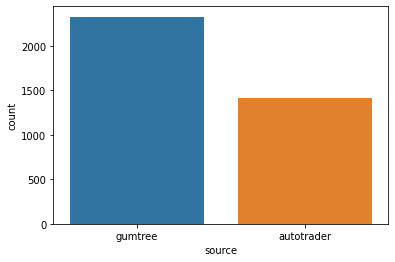

In [47]:
sns.countplot(data['source']);


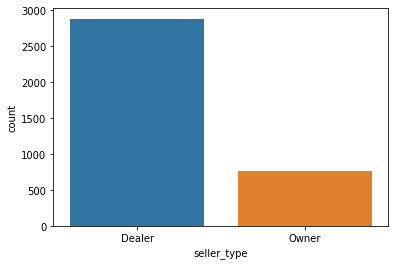

In [49]:
sns.countplot(data['seller_type'])

10  bikes have more than 150 000km


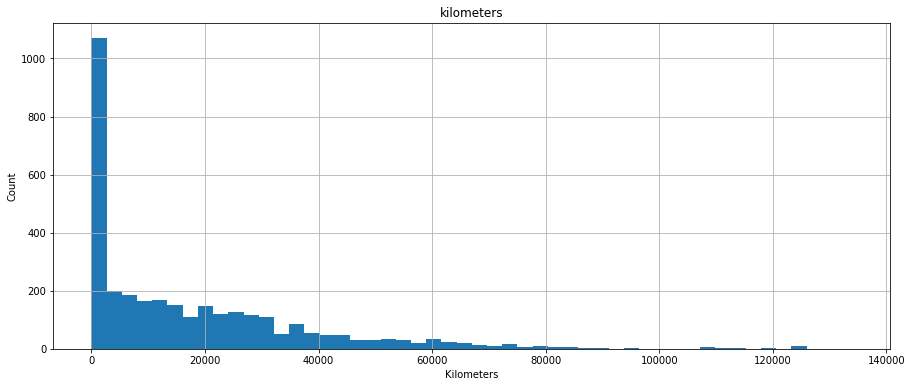

In [50]:
data_selected = data[data['kilometers'] < 150000]
data_selected.hist(['kilometers'], bins=50, figsize=(15, 6))
print(data[data['kilometers'] > 150000].shape[0], " bikes have more than 150 000km")
plt.ylabel('Count')
plt.xlabel('Kilometers');

5  ads have a price higher than 600 000R


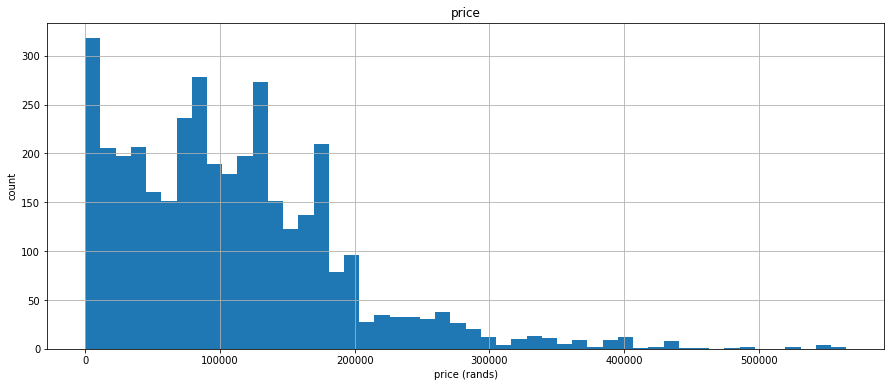

In [51]:
data_selected = data[data['price'] < 600000]
data_selected.hist(['price'], bins=50, figsize=(15, 6))
print(data[data['price'] > 600000].shape[0], " ads have a price higher than 600 000R")
plt.ylabel('count')
plt.xlabel('price (rands)');

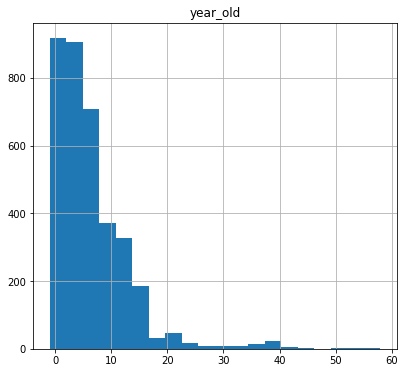

In [52]:
data[['year_old']].hist(bins=20, figsize=(15, 6), layout=(1, 2));

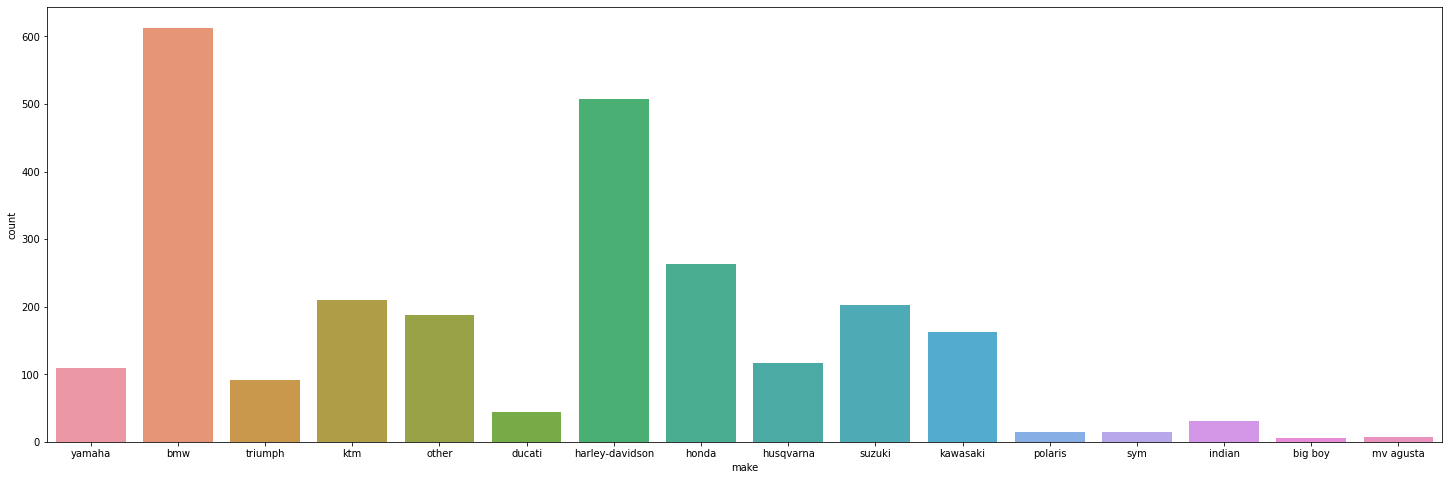

In [53]:
data_selected = data[data["count_id"] > 4]
fig, ax = plt.subplots(figsize=(25,8))
sns.countplot(ax = ax, x = data_selected['make']);

# Analysis

### Analyse a special bike

In [54]:
#Scatter plot kilometer vs price
def price_kilometer_plot(make, model, engine_displacement):
    id = make + model + engine_displacement
    bikes = data[data["id"] == id]
    
    fig = plt.figure(figsize=(15, 7))
    fig.set
    ax = fig.add_axes([0,0,1,1])
    ax.scatter(bikes['kilometers'], bikes['price'], color='b')
    ax.set_xlabel('kilometers', fontsize=25)
    ax.set_ylabel('price', fontsize=25)

    #ax.set_title('scatter plot')
    plt.show()
    

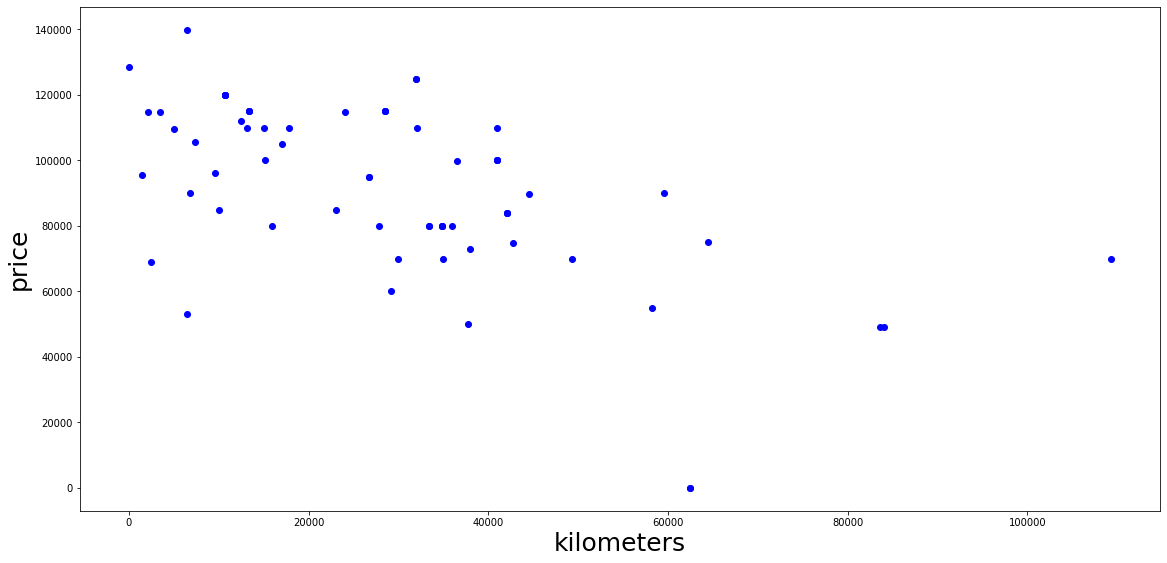

In [55]:
price_kilometer_plot("bmw", "f series", "800")

# Mathematical models for estimating the price of bike

In [163]:
#Selection of the data for training the model:
print("Number of bikes before: ", data.shape[0])
threshold = 25 #Minimum number of bike per model
data_model = data[data['count_id'] >= threshold]
print("Number of bikes after removing the model below the threshold: ", data_model.shape[0])

data_model = data_model[data_model['kilometers'].notnull()]
print("Number of bike after removing the ads which doesn't include the kilometers", data_model.shape[0])

data_model = data_model[data_model['year'].notnull()]
print("Number of bikes after removing the ads without year: ", data_model.shape[0])

data_model = data_model[data_model['price'] > 0]
print("Number of bikes after removing the ads without price: ", data_model.shape[0])

data_model = data_model[data_model['engine_displacement'].notnull()]
print("Number of bikes after removing ads without engine displacement: ", data_model.shape[0])

data_model = data_model[data_model['model'] != 'other']
print("Number of bikes after removing the ads without model: ", data_model.shape[0])

print("Number of models: ", len(set(data_model['id'].values)))

Number of bikes before:  3747
Number of bikes after removing the model below the threshold:  1287
Number of bike after removing the ads which doesn't include the kilometers 1164
Number of bikes after removing the ads without year:  1163
Number of bikes after removing the ads without price:  1134
Number of bikes after removing ads without engine displacement:  1134
Number of bikes after removing the ads without model:  1006
Number of models:  19


In [164]:
#Mathematical models are going to be built. Each bike ID will have a specific model
#I assumed that the evolution of the bike price depends on the model of the bike

In [165]:
bikes_per_id = data_model.groupby(['id'])['count_id'].first()
bikes_per_id

id
bmwf series800                   67.0
bmwr series1170                  26.0
bmwr series1200                 252.0
bmwr series1250                  31.0
bmws series1000                  51.0
harley-davidsonsoftailn          33.0
harley-davidsonsportster1200     56.0
harley-davidsonsportster883      33.0
harley-davidsontouringn         124.0
hondacbr1000                     61.0
hondacbr600                      33.0
hondacrf250                      29.0
hondanc750                       30.0
kawasakiz series1000             44.0
ktmadventure1190                 44.0
suzukigsx1000                    58.0
triumphbonneville1200            27.0
triumphtiger800                  26.0
yamahayzf1000                    26.0
Name: count_id, dtype: float64

In [166]:
print('On average, there are  ', int(bikes_per_id.mean()), ' bikes per id for building the mathematical model')


On average, there are   55  bikes per id for building the mathematical model


Text(0, 0.5, 'Count')

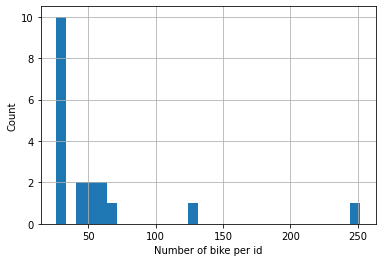

In [143]:
bikes_per_id.hist(bins = 30)
plt.xlabel("Number of bike per id")
plt.ylabel("Count")

In [167]:
#When we look at the hist, we see that most of the id doesn't have 50 bikes per id.
print("The median of the number of bike per id is: ", bikes_per_id.median())

The median of the number of bike per id is:  33.0


In [168]:
#Because we don't have a lot of data, we won't split the data in training, testing and validation subdataset.
#A cross validation could be done though. A visual analysis could be as effective for selecting the model.

In [355]:
def plot_model_linear(x,y,model, xlabel, ylabel, title):
    
    x_model = np.arange(0,max(x), 0.01)
    
    y_model = reg.predict(x_model.reshape(-1, 1))
    
    fig = plt.figure(figsize = (10, 7))
    
    fig.set
    
    ax = fig.add_axes([0,0,1,1])
    
    ax.scatter(x, y, color='b')
    
    ax.scatter(x_model, y_model, color = 'r')
    
    ax.set_xlabel(xlabel, fontsize=20)
    
    ax.set_ylabel(ylabel, fontsize=20)

    ax.set_title(title)
    plt.show()
    

## Linear regression, kilometers on price.

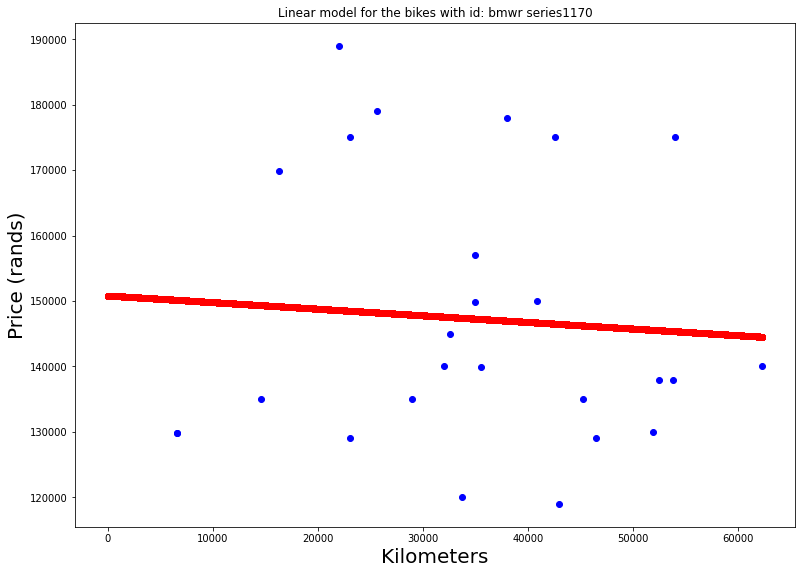

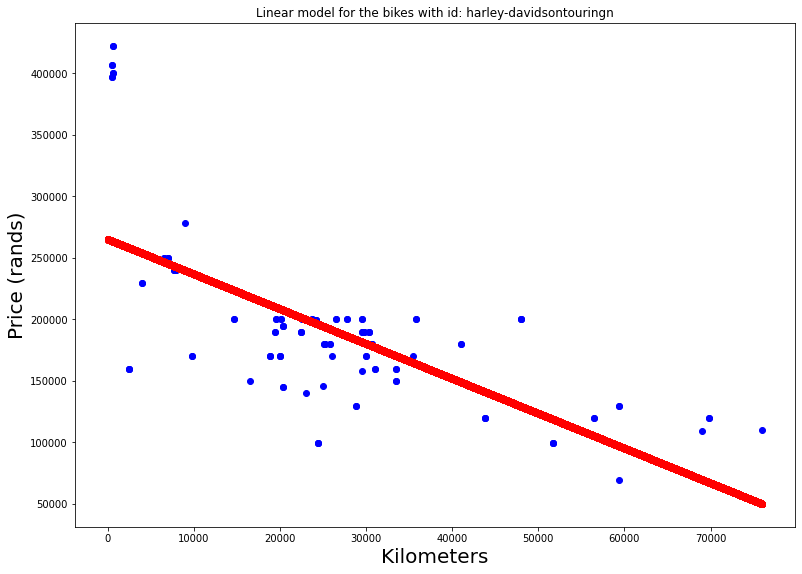

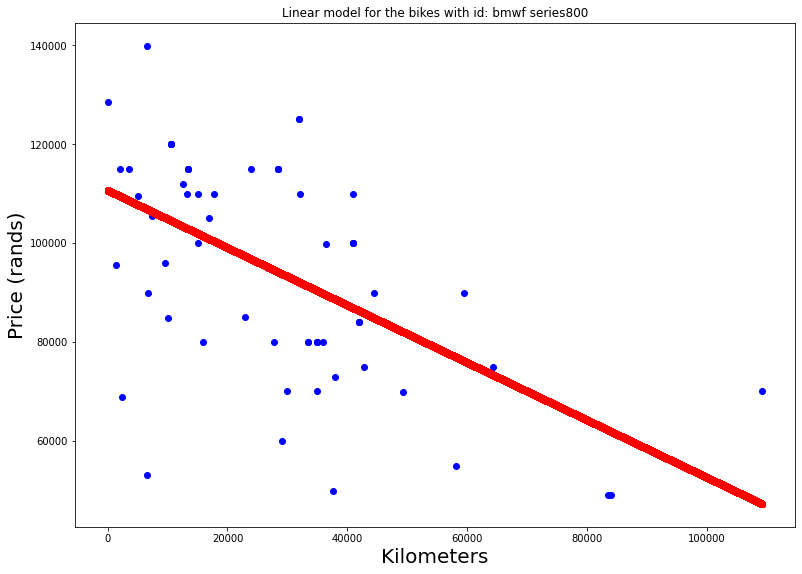

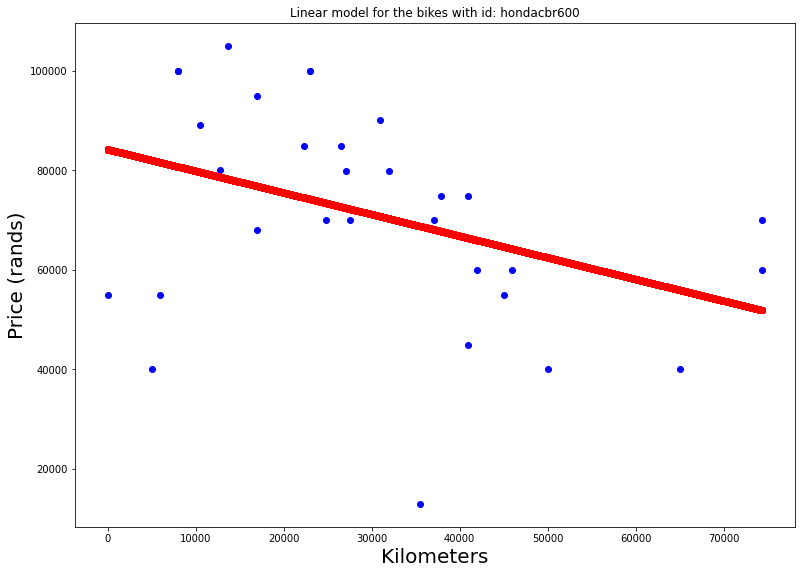

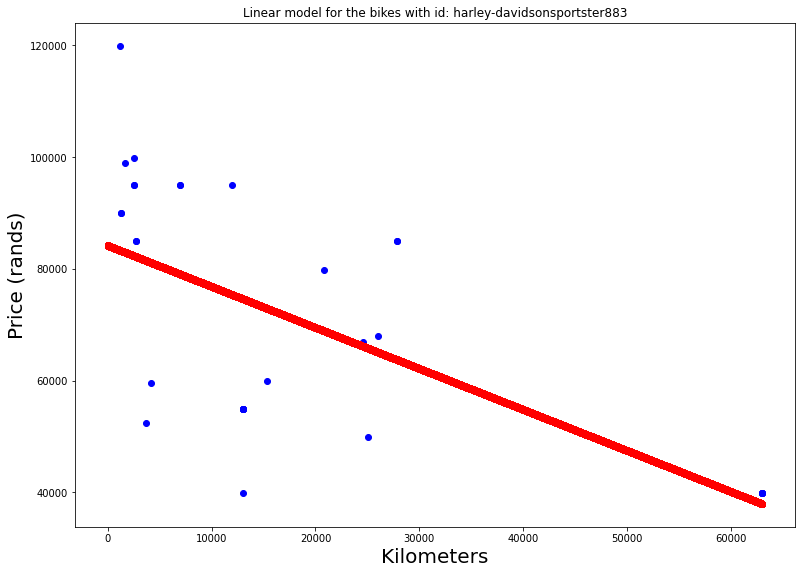

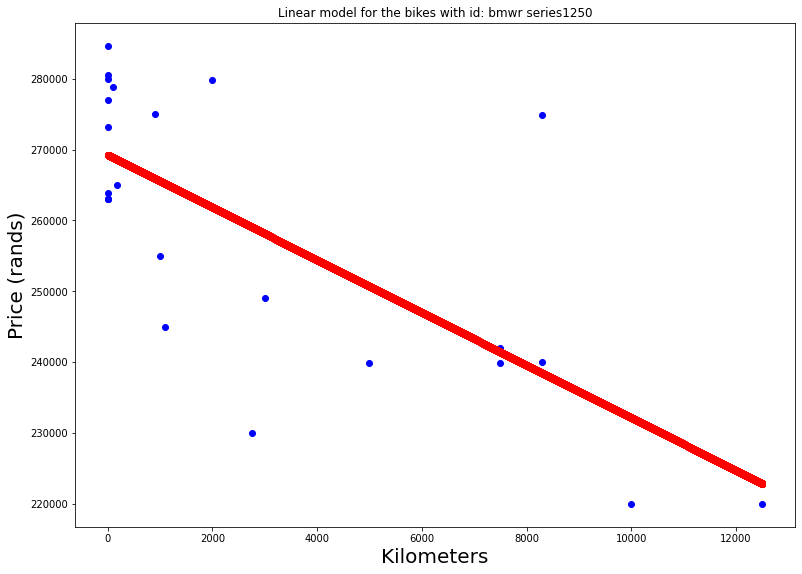

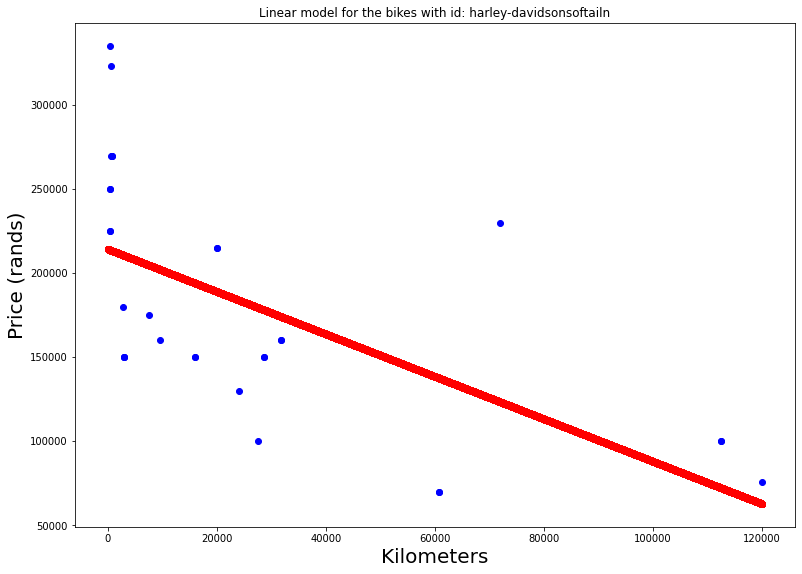

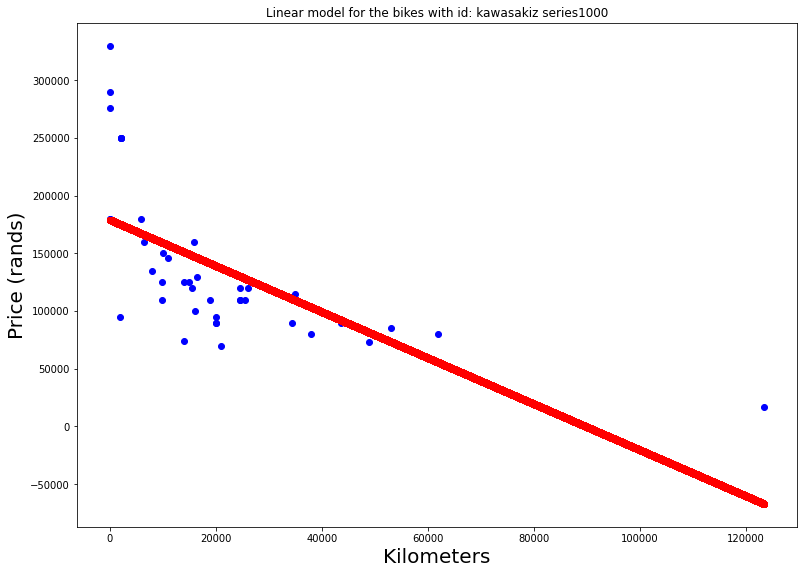

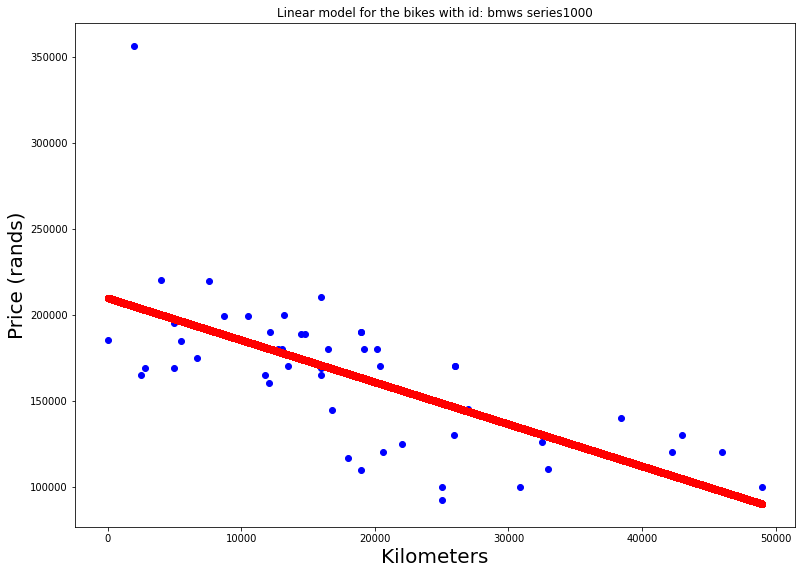

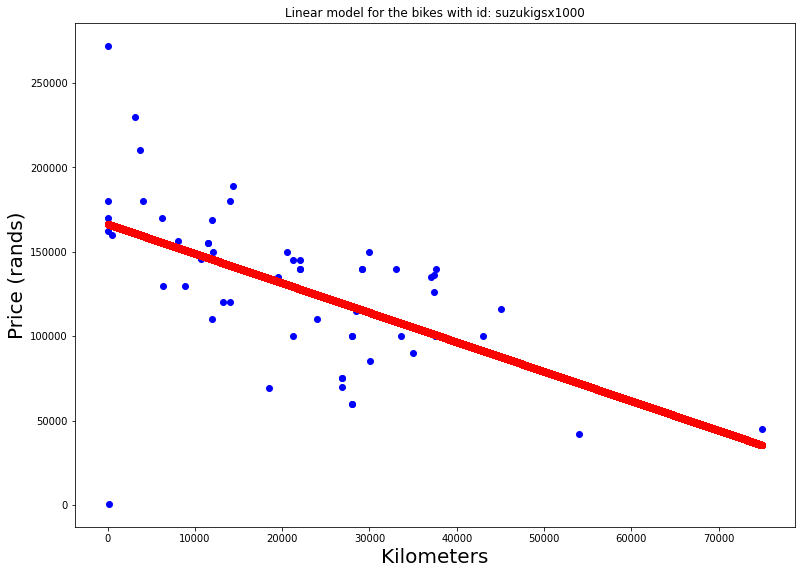

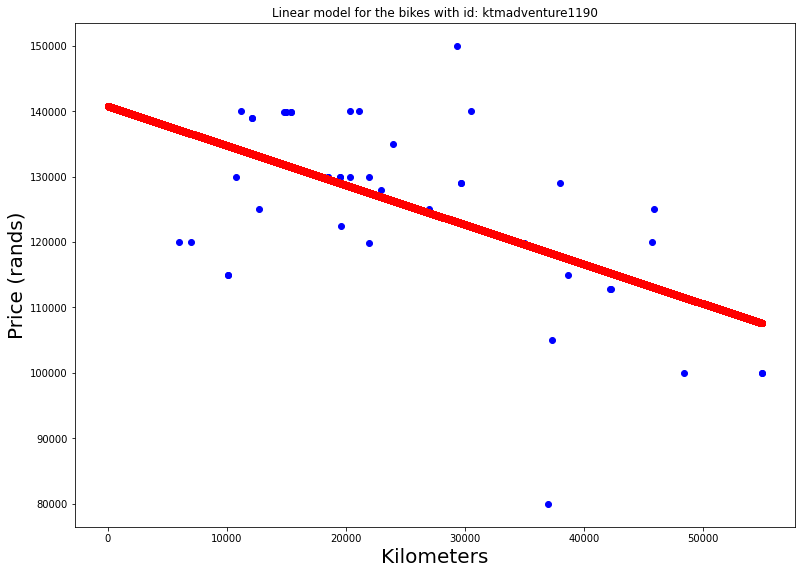

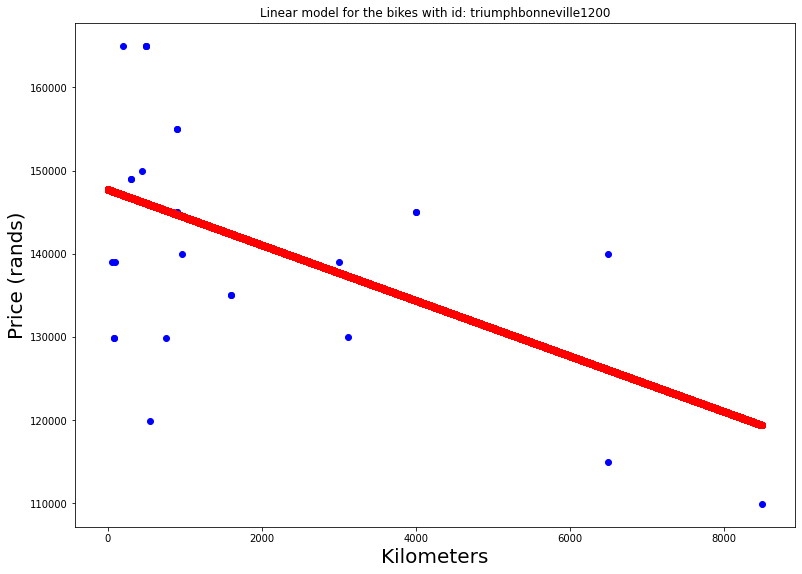

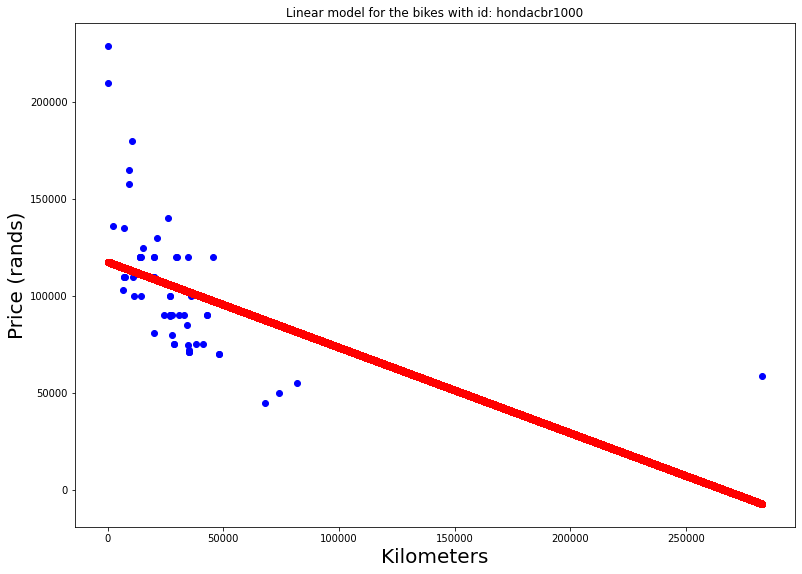

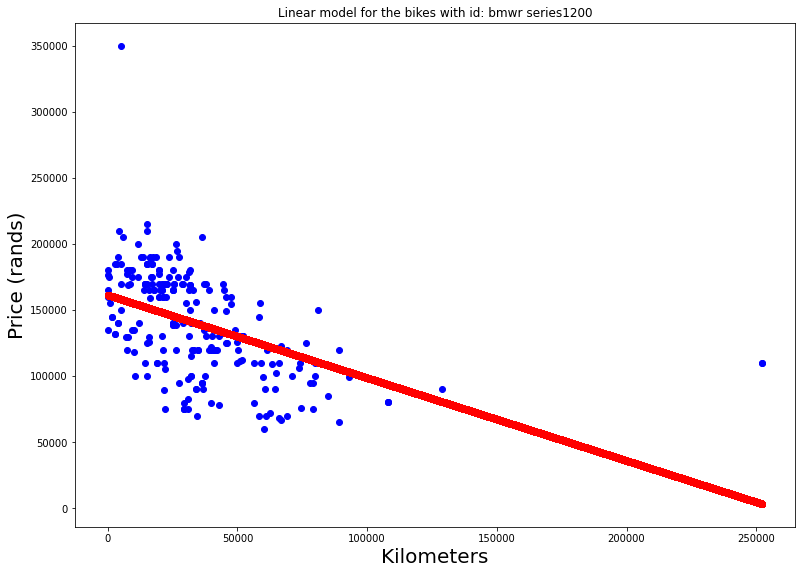

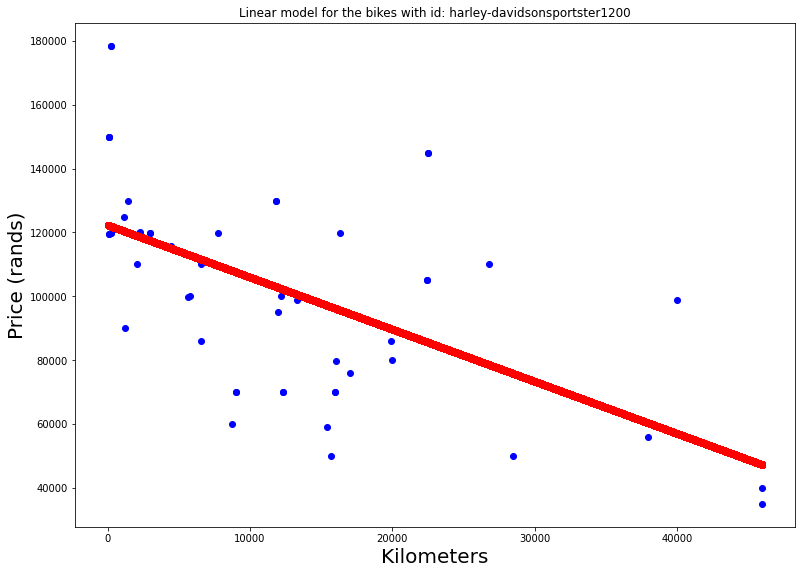

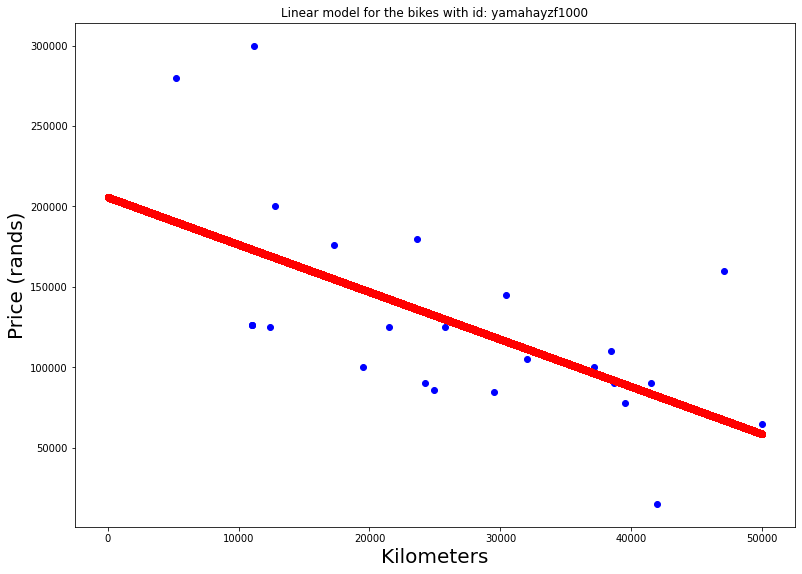

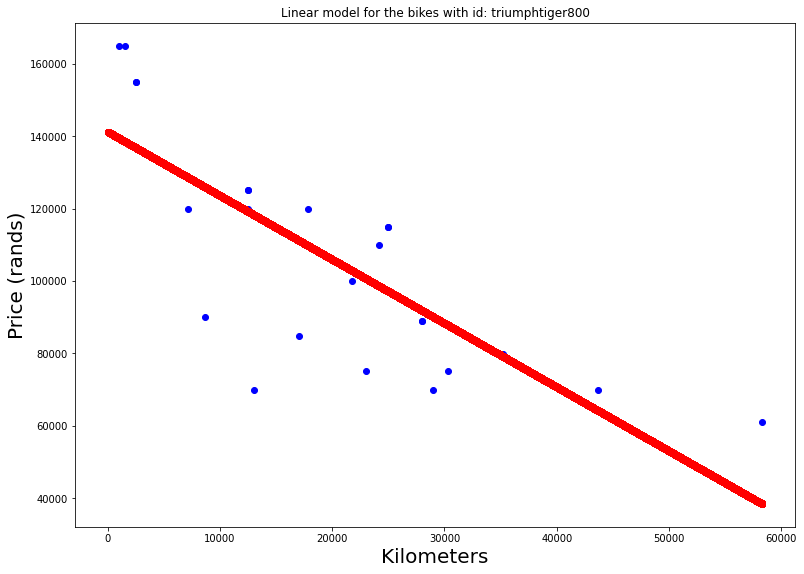

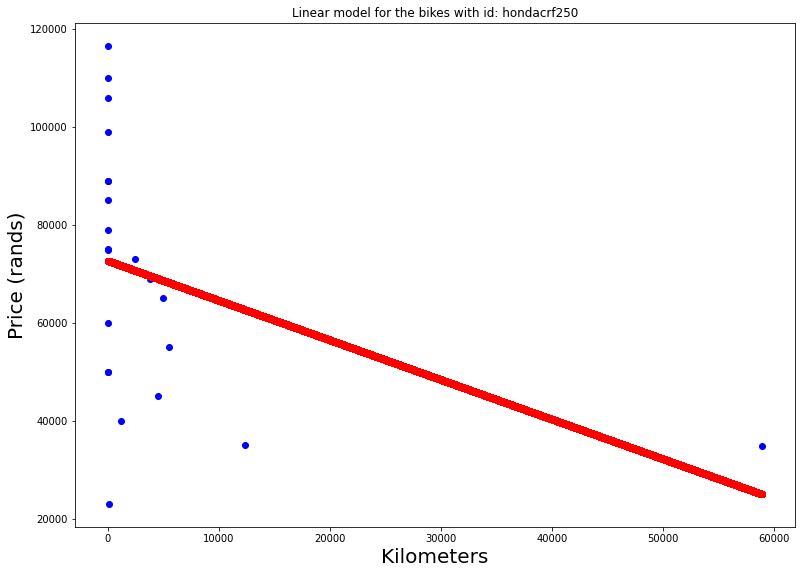

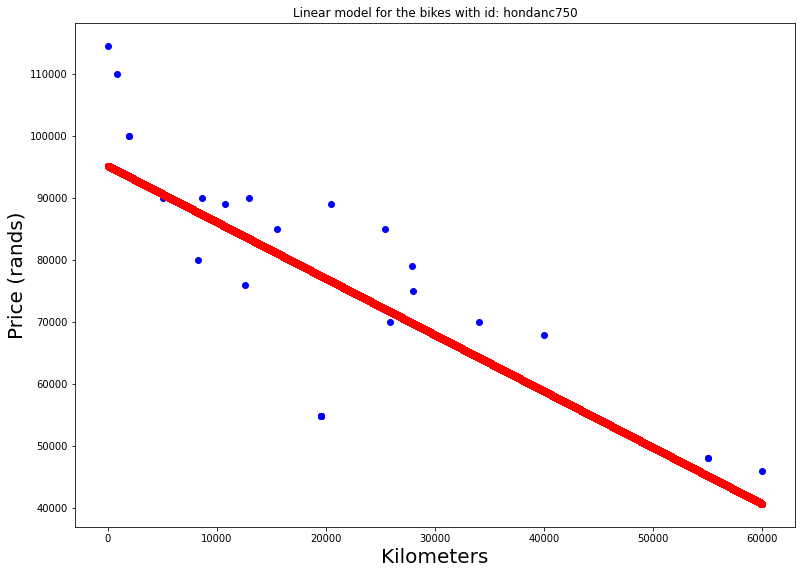

In [170]:
# A model per bike id is created. These plots are usefull to check if the linear model is working for the different bike models.

coefs_lr = [] #Coefs of the regression for further analysis
rmse_lr = [] #Error of the model per bike
number_of_bikes = []

for idx in set(data_model['id'].values):
    
    reg = linear_model.LinearRegression() 
    
    x = data_model[data_model["id"] == idx]['kilometers'].values.reshape(-1, 1)
    
    y = data_model[data_model["id"] == idx]['price'].values
    
    reg.fit(x, y)
    
    coef = reg.coef_
    
    coefs_lr.append(coef)
    
    y_pred = reg.predict(x)
    
    error = mean_squared_error(y, y_pred, squared = False)
    
    rmse_lr.append(error)
    
    number_of_bikes.append(data_model[data_model["id"] == idx].shape[0])
    
    plot_model_linear(x,y,reg, "Kilometers", "Price (rands)", "Linear model for the bikes with id: {}".format(idx))
    

In [171]:
print("Mean of the Root Mean Square Error of the ", len(rmse_lr), " linear models created: ", int(np.mean(rmse_lr)))

print("Weighted mean of the Root Mean Square Error (weighted per the number of bikes) :", int(np.average(rmse_lr, weights=number_of_bikes)))


Mean of the Root Mean Square Error of the  19  linear models created:  28166
Weighted mean of the Root Mean Square Error (weighted per the number of bikes) : 31687


## Polynomial model, 1 variable (kilometers)

In [172]:
#A polynomial regression of degree 2 is built for each id.
def plot_polynomial_model(x,y,xlabel, ylabel, title):
    #Create the model:
    polynomial_features= PolynomialFeatures(degree=2)
    
    x_poly = polynomial_features.fit_transform(x.values.reshape(-1,1))
    
    model = linear_model.LinearRegression() 
    
    model.fit(x_poly, y)
    
    #Fit the line
    x_model = np.arange(0,max(x), 1).reshape(-1, 1)
    
    x_poly_model = polynomial_features.fit_transform(x_model)
    
    y_poly_model_pred = model.predict(x_poly_model)
    
    #Plot
    fig = plt.figure(figsize = (10, 7))
    
    fig.set
    
    ax = fig.add_axes([0,0,1,1])
    
    ax.scatter(x, y, color='b')
    
    ax.scatter(x_model, y_poly_model_pred, color = 'r')
    
    ax.set_xlabel(xlabel, fontsize=20)
    
    ax.set_ylabel(ylabel, fontsize=20)

    ax.set_title(title)
    
    plt.show()
    

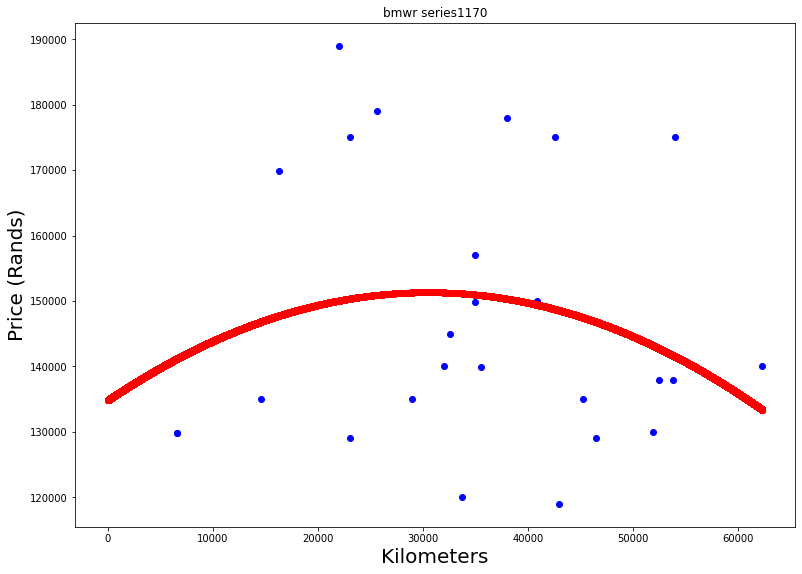

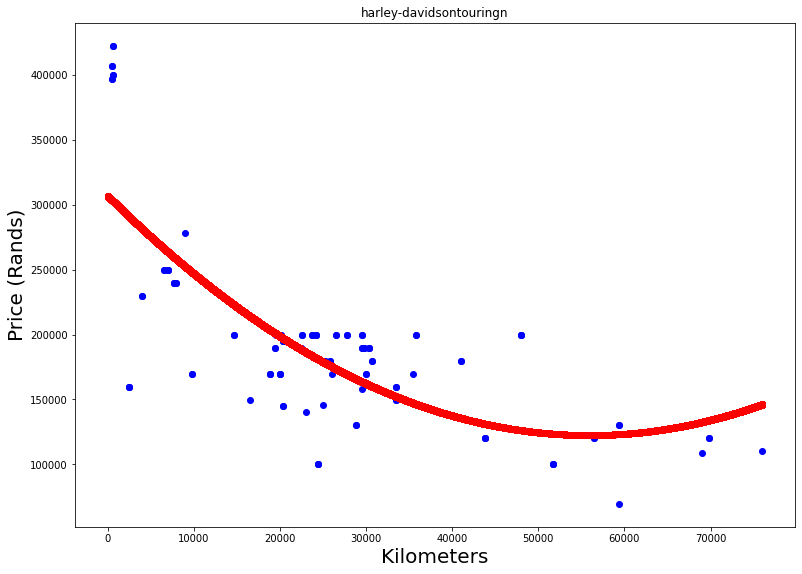

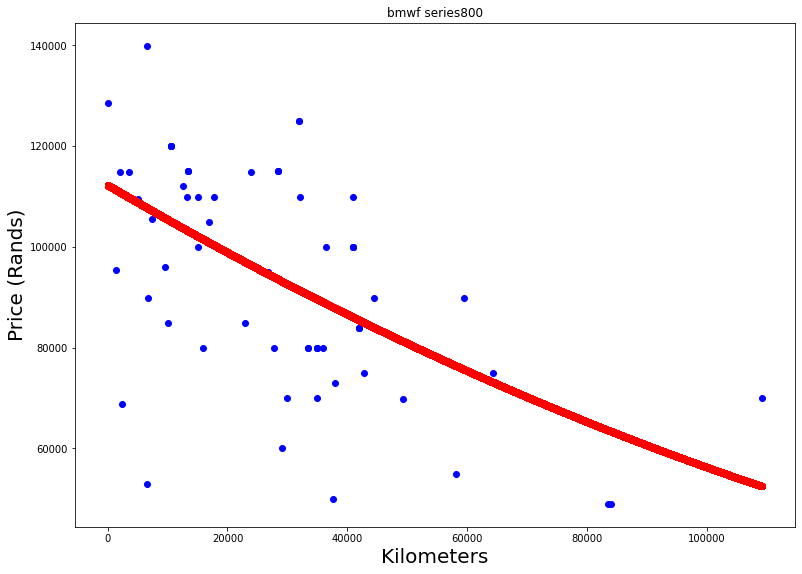

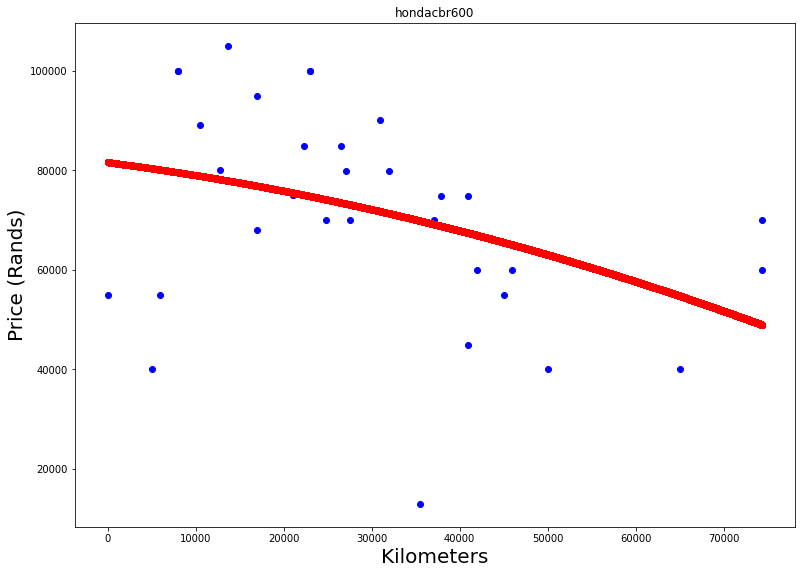

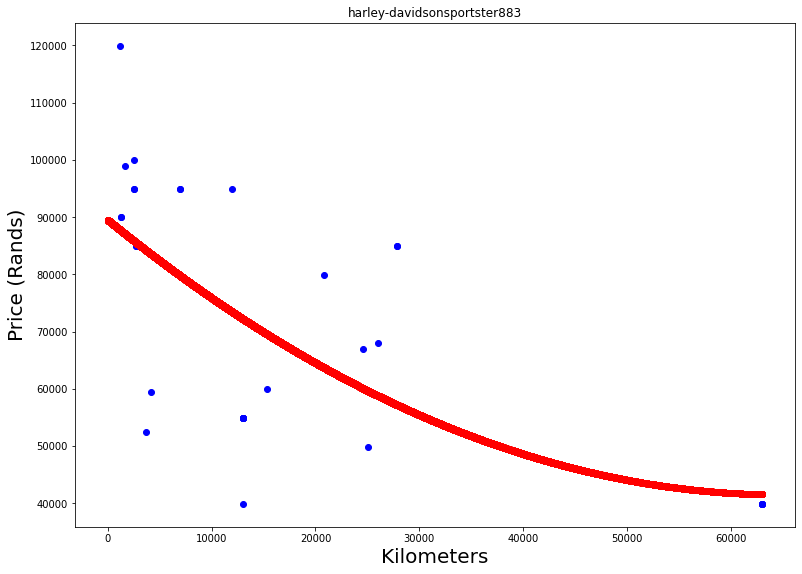

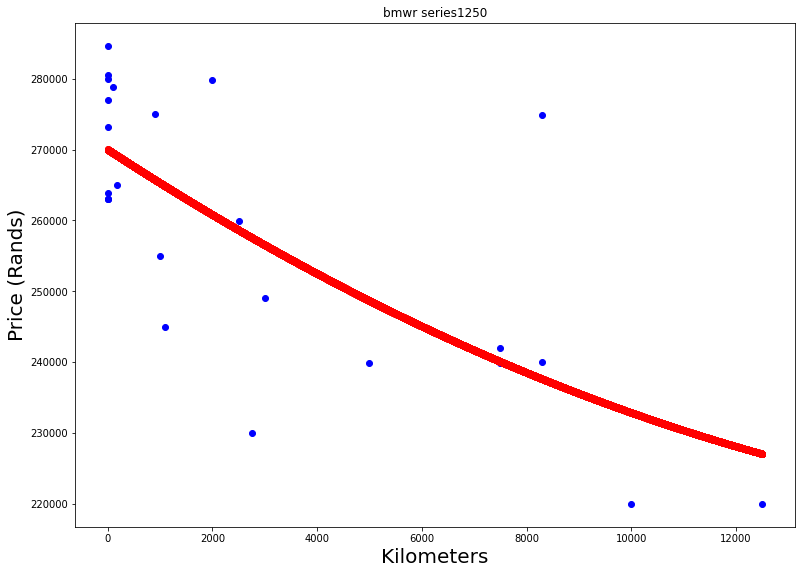

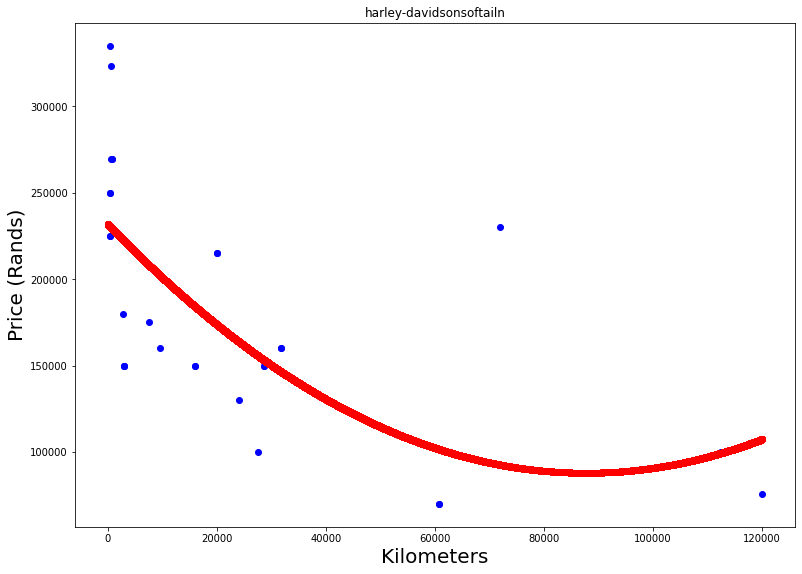

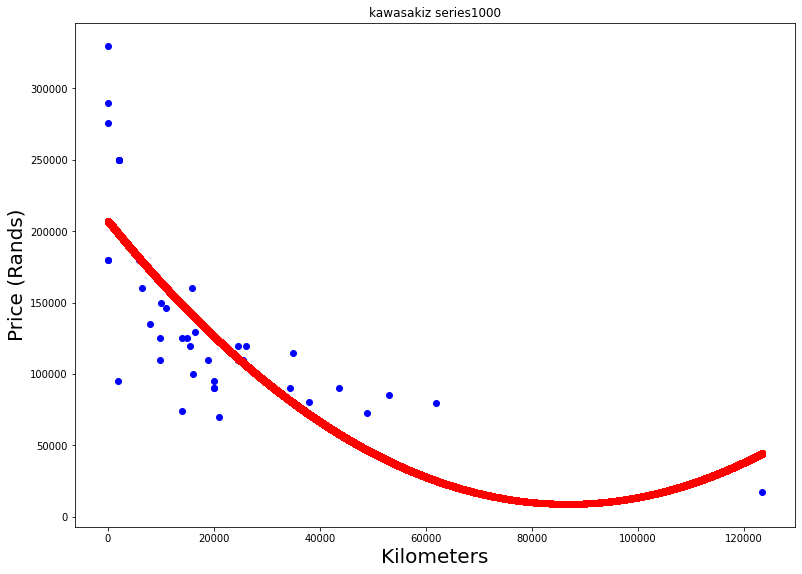

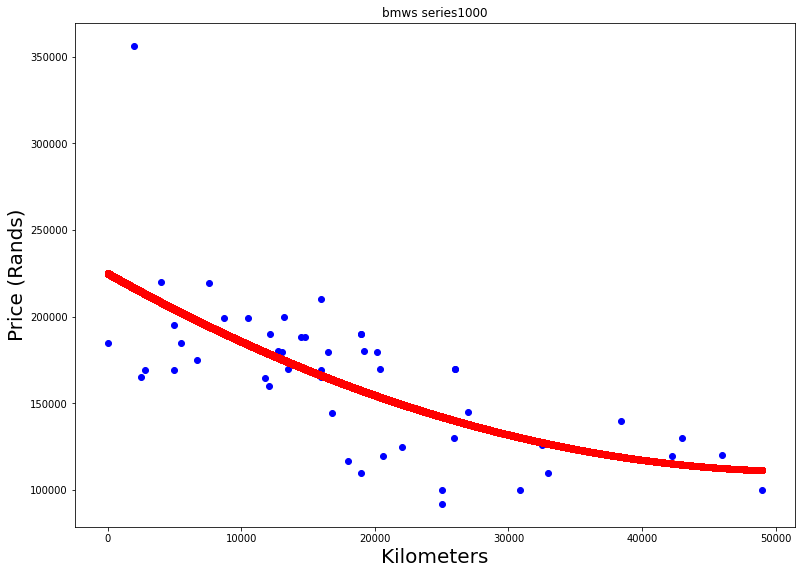

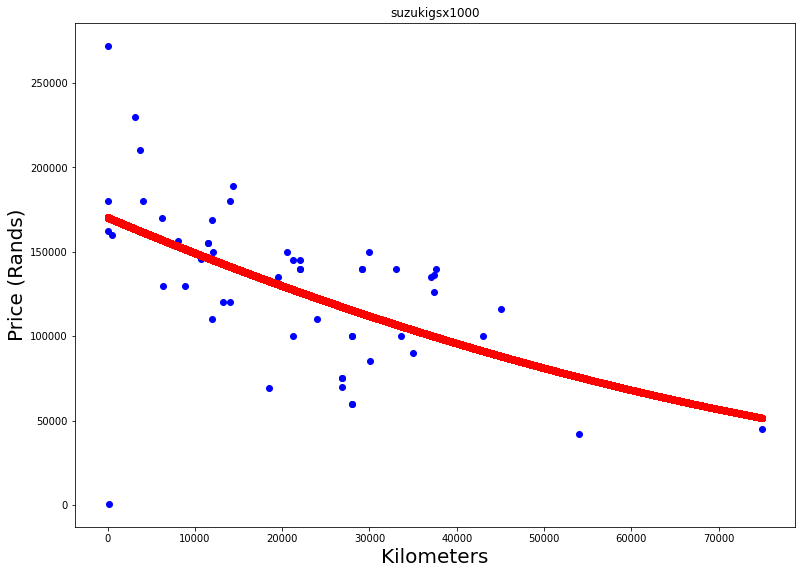

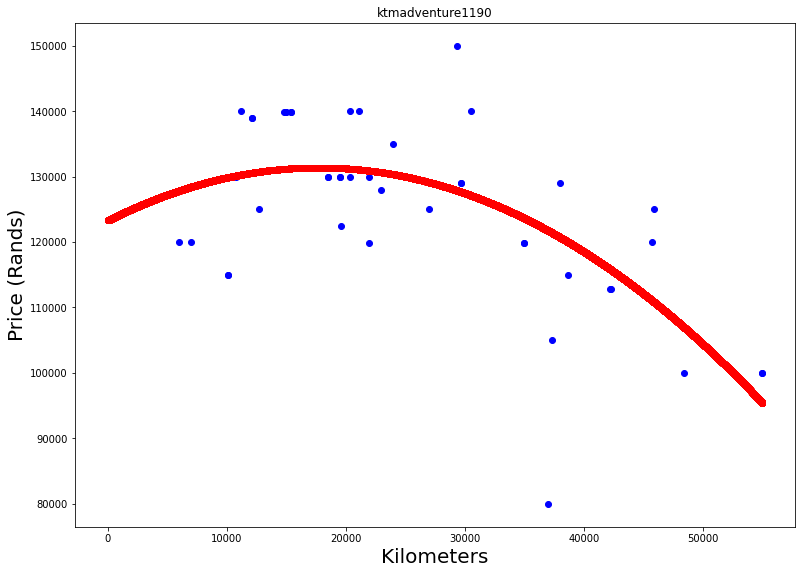

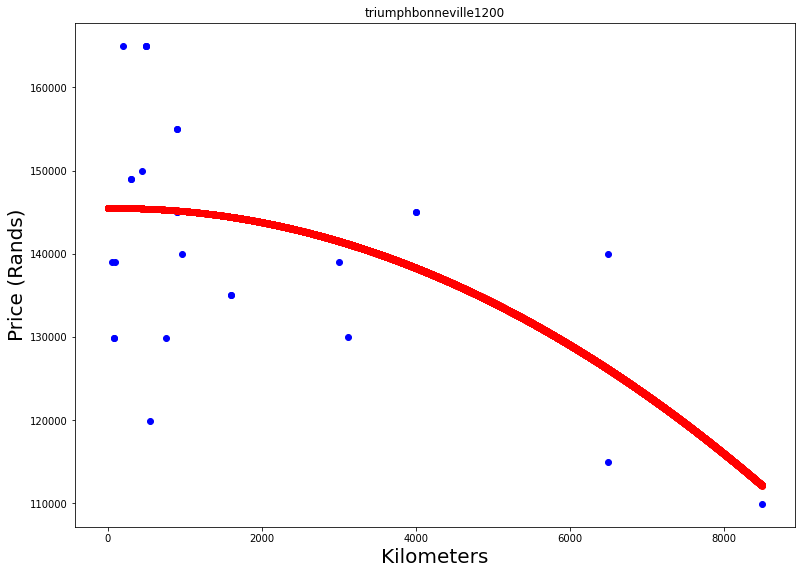

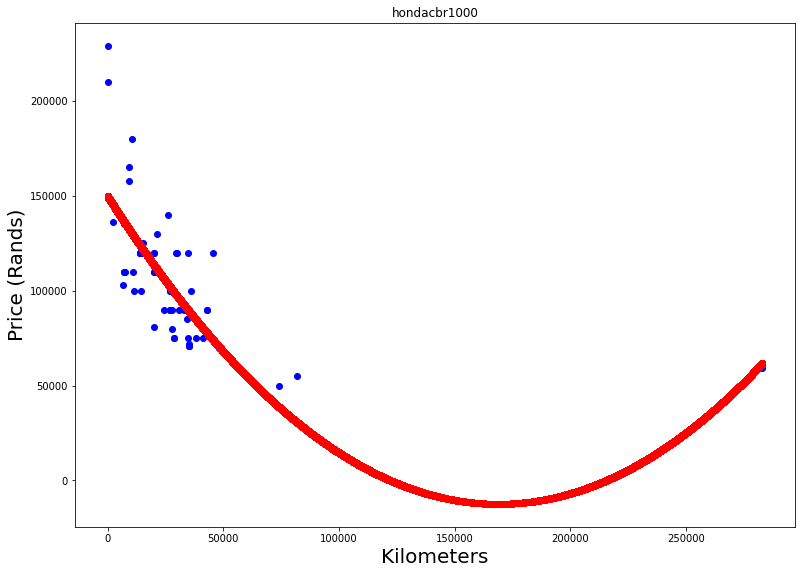

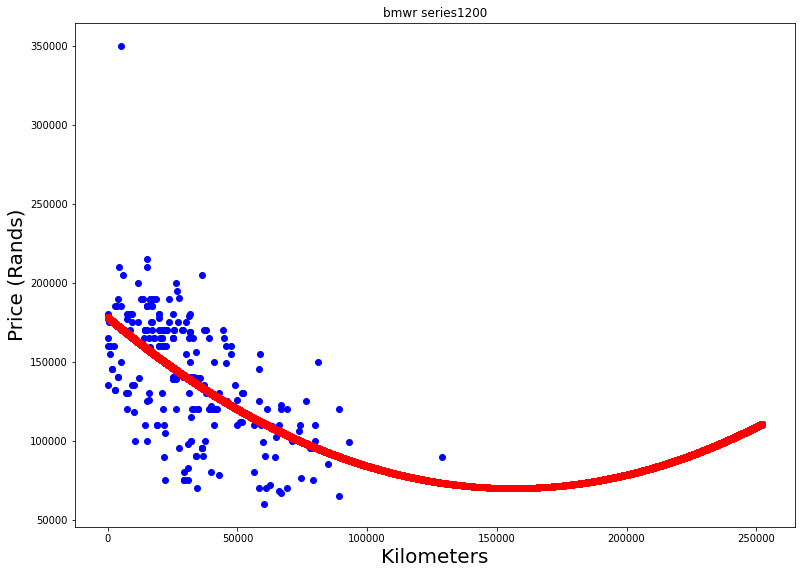

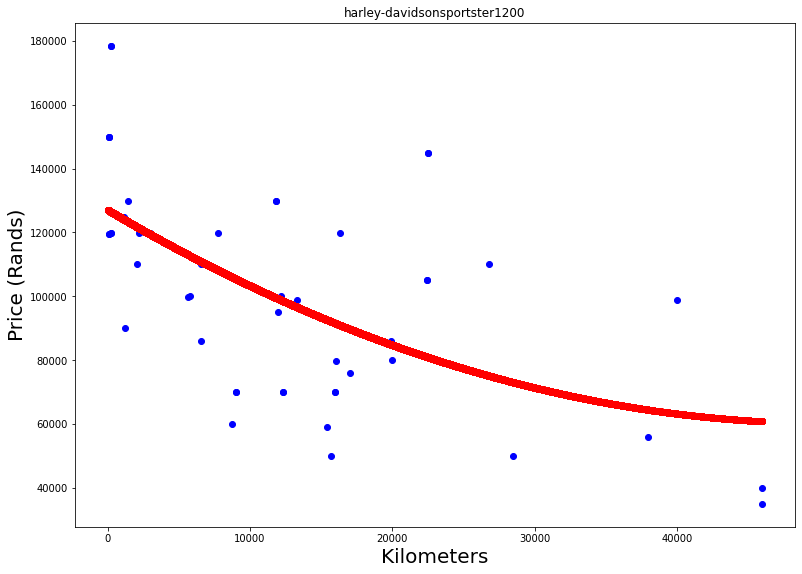

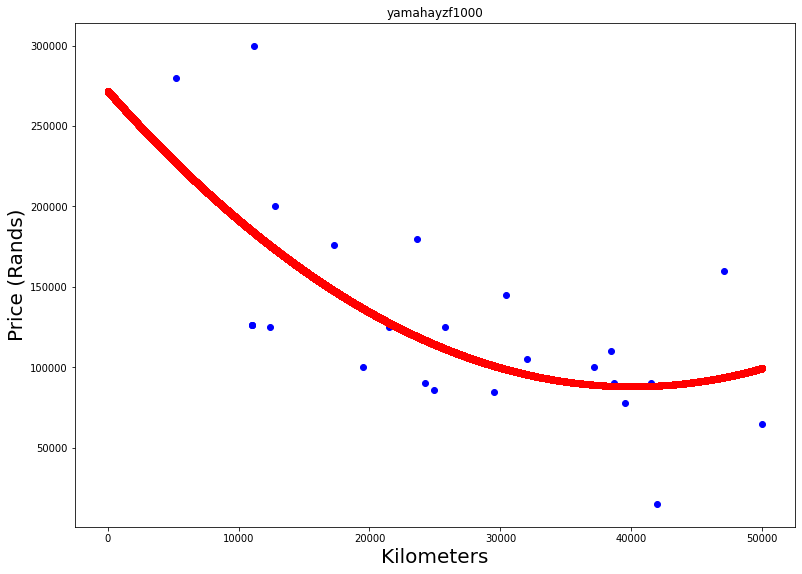

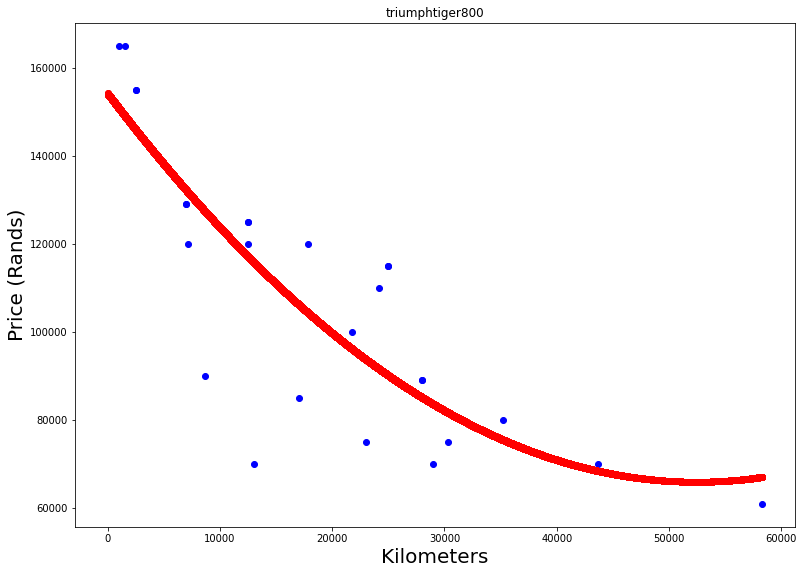

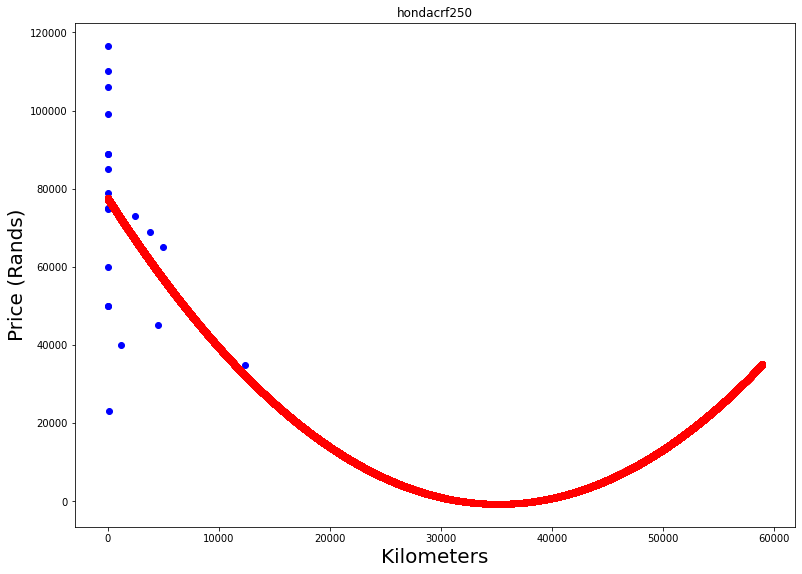

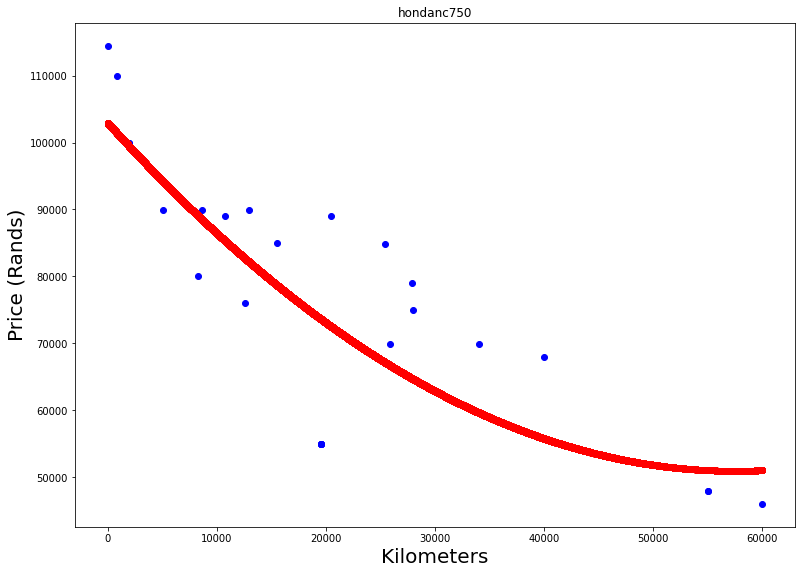

In [173]:
rmse_poly = []

for idx in set(data_model['id'].values):
    
    x = data_model[data_model['id'] == idx]['kilometers']
    
    y = data_model[data_model['id'] == idx]['price']
    
    plot_polynomial_model(x,y, "Kilometers", "Price (Rands)", idx)
    
    polynomial_features= PolynomialFeatures(degree=2)
    
    x_poly = polynomial_features.fit_transform(x.values.reshape(-1,1))
    
    model = linear_model.LinearRegression() 
    
    model.fit(x_poly, y)
    
    y_pred = model.predict(x_poly)
    
    error = mean_squared_error(y, y_pred, squared = False)
    
    rmse_poly.append(error)

In [174]:
print("Root Mean Square Error of the ", len(rmse_lr), " linear models created: ", int(np.array(rmse_poly).mean()))

print("Weighted mean of the Root Mean Square Error (weighted per the number of bikes) :", int(np.average(rmse_poly, weights=number_of_bikes)))
#The RMSE is better, but the polynomial models are overfitting the data too much.


Root Mean Square Error of the  19  linear models created:  26129
Weighted mean of the Root Mean Square Error (weighted per the number of bikes) : 29170


## Linear regression, year on price.


bmwr series1170


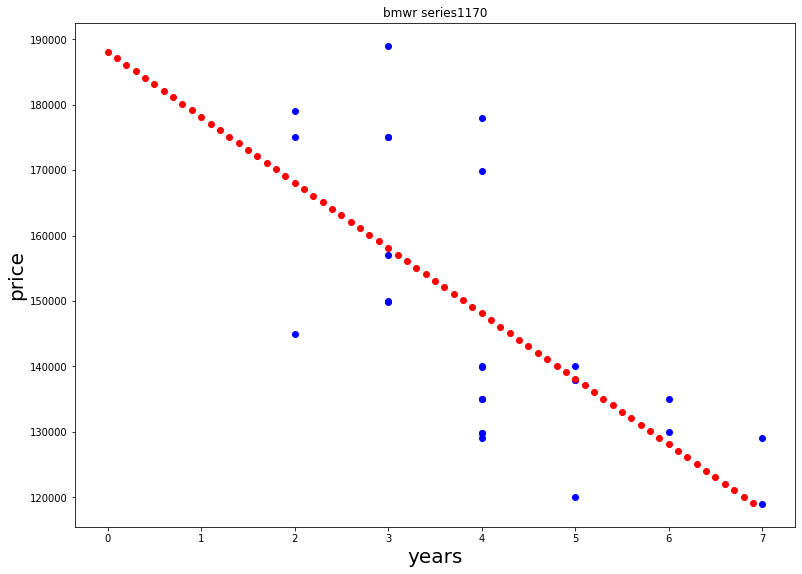

harley-davidsontouringn


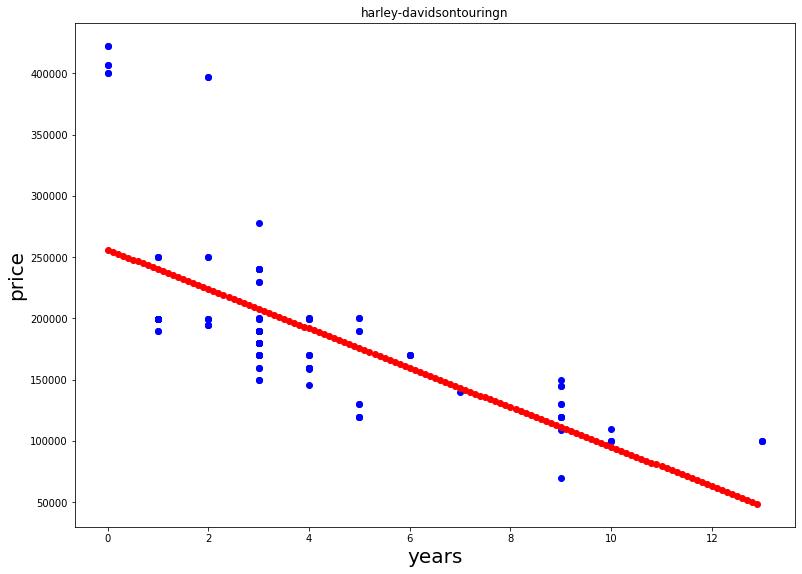

bmwf series800


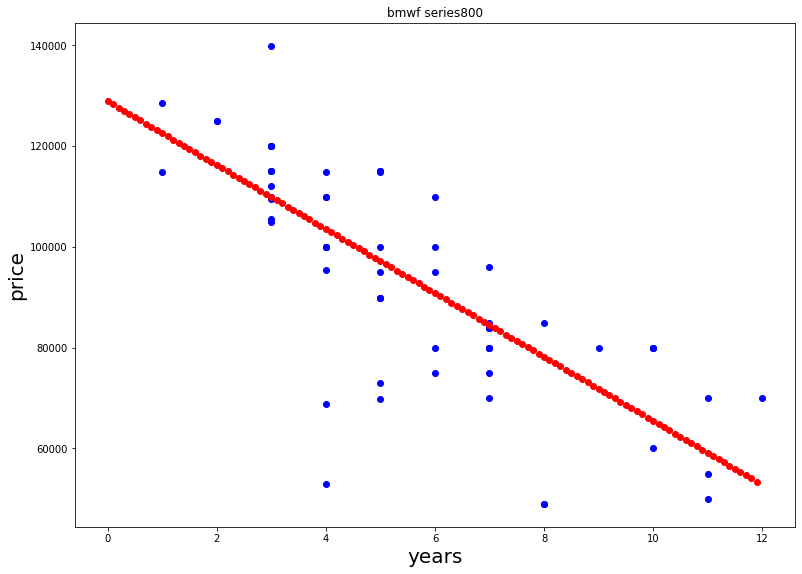

hondacbr600


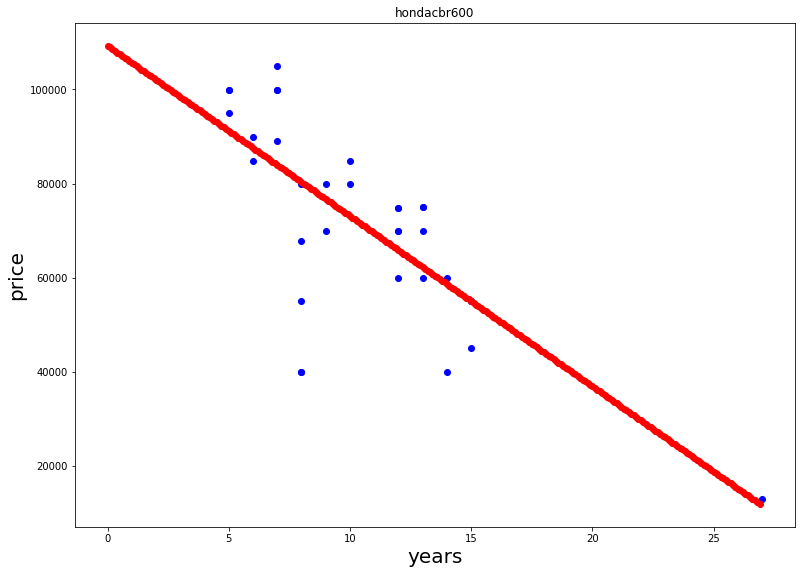

harley-davidsonsportster883


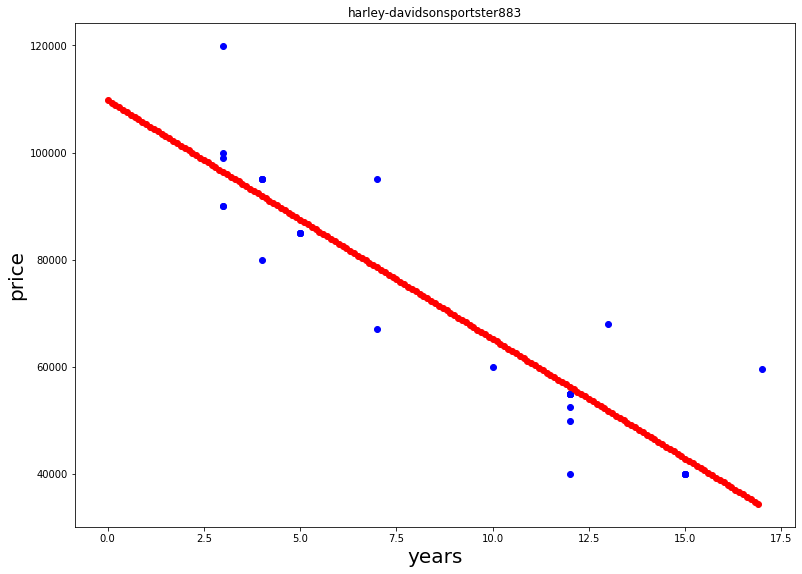

bmwr series1250


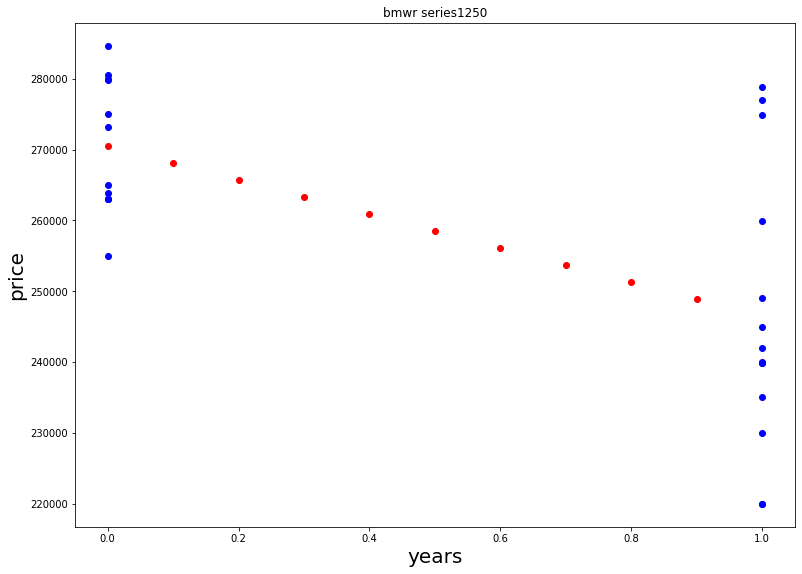

harley-davidsonsoftailn


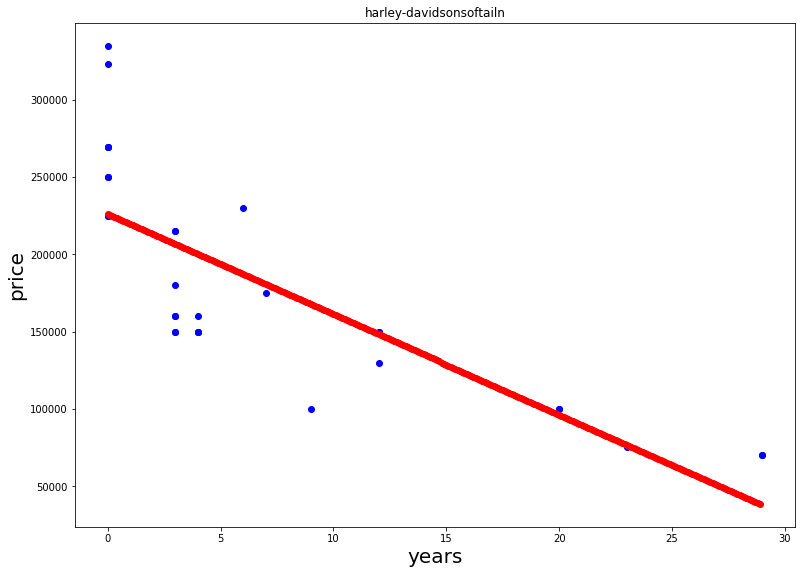

kawasakiz series1000


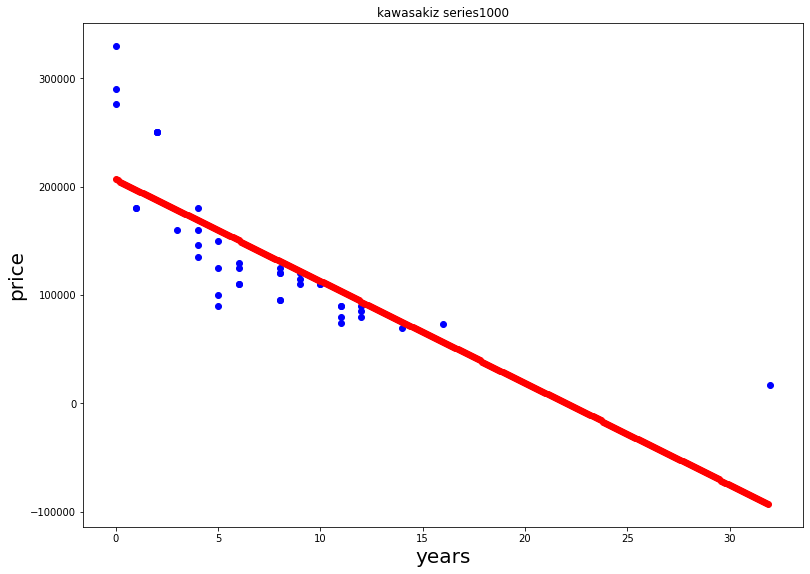

bmws series1000


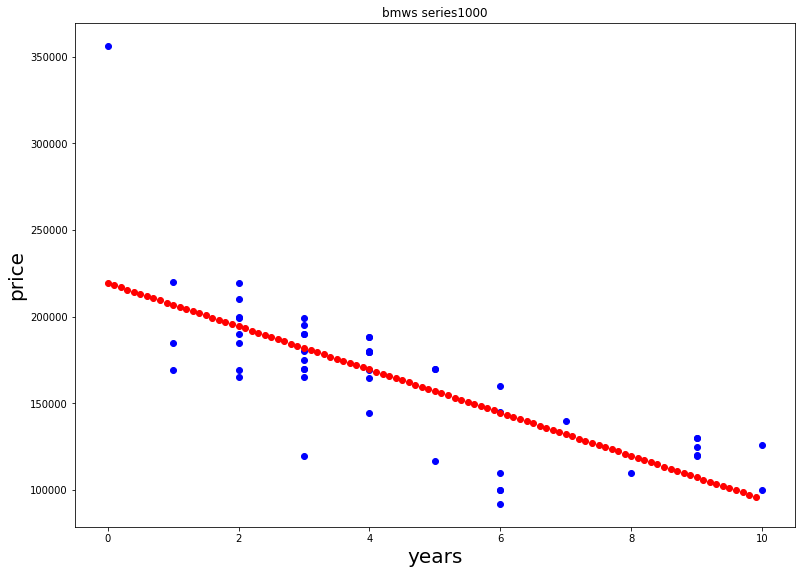

suzukigsx1000


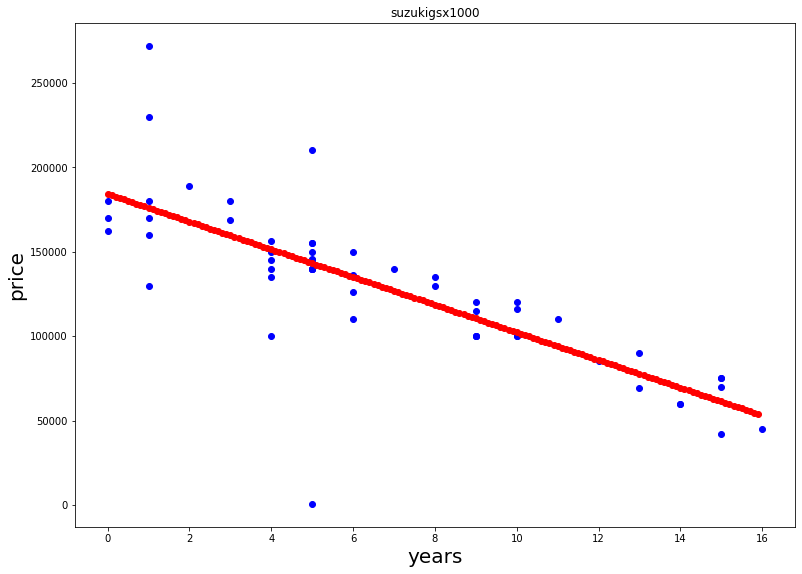

ktmadventure1190


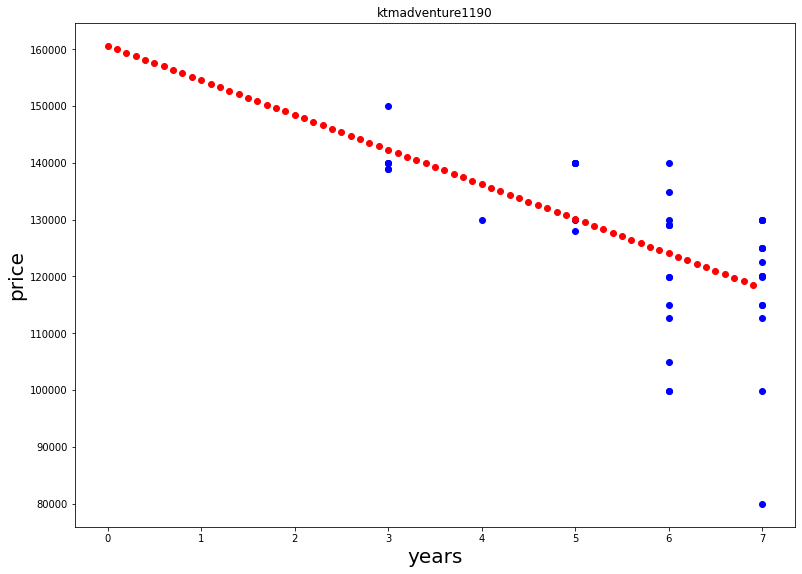

triumphbonneville1200


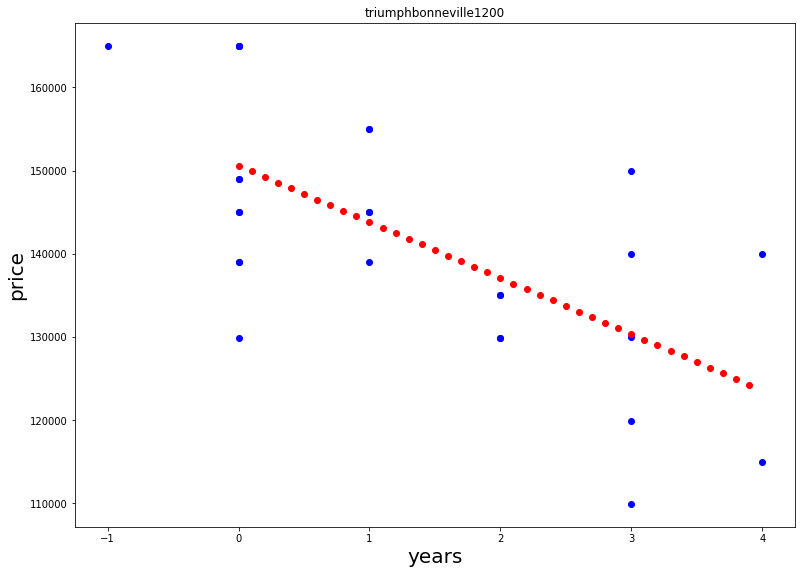

hondacbr1000


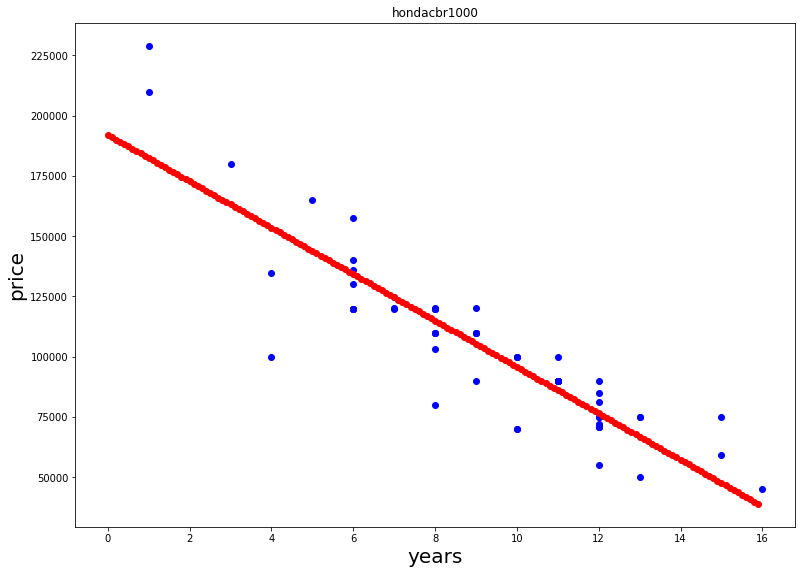

bmwr series1200


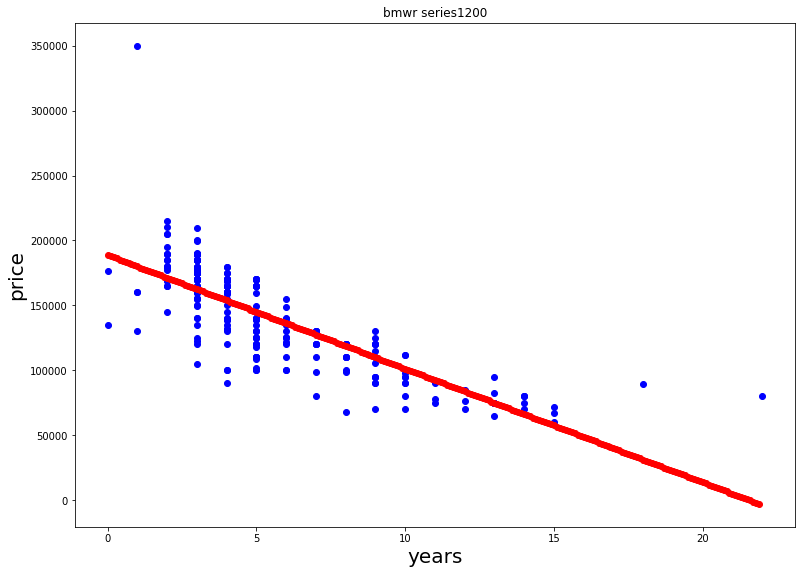

harley-davidsonsportster1200


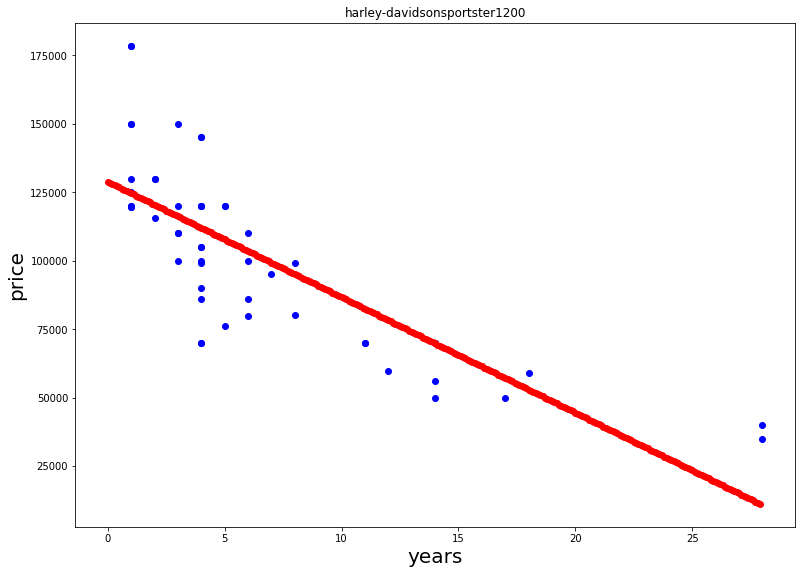

yamahayzf1000


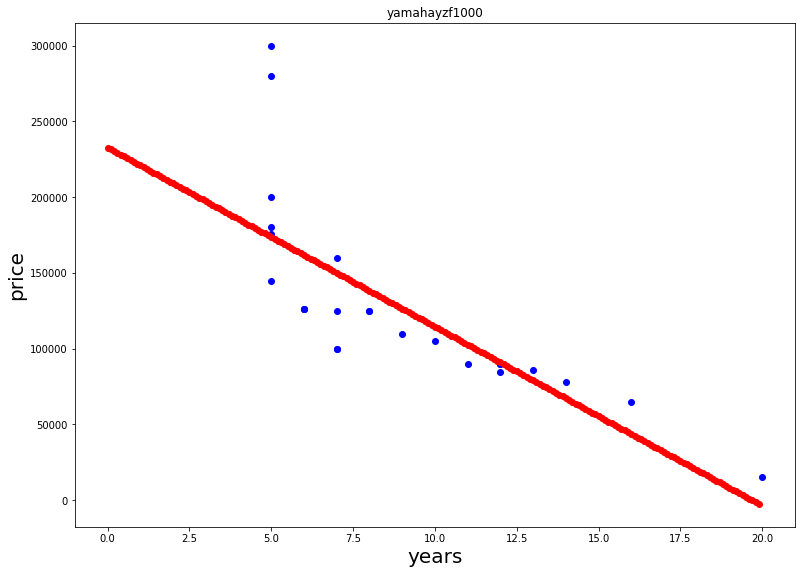

triumphtiger800


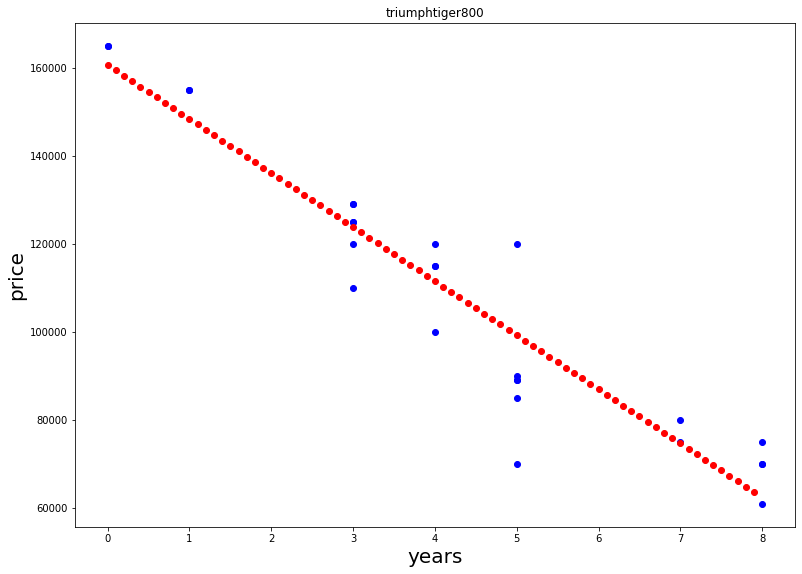

hondacrf250


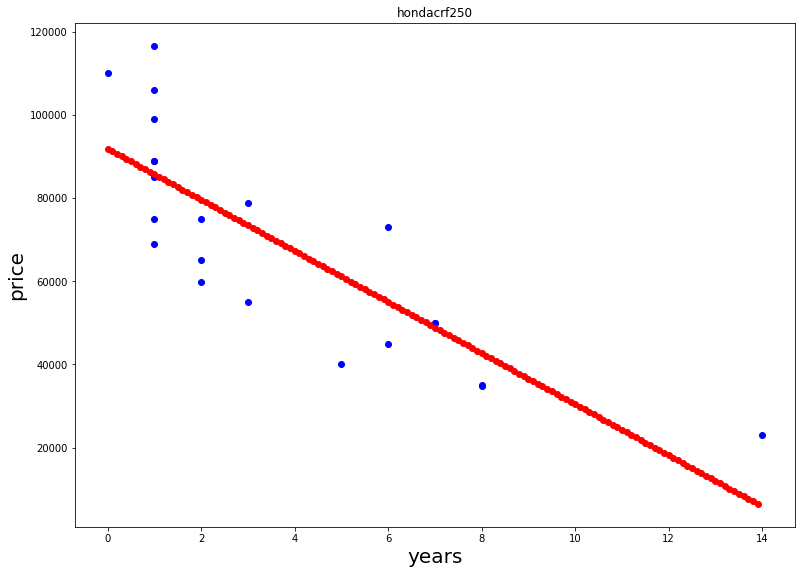

hondanc750


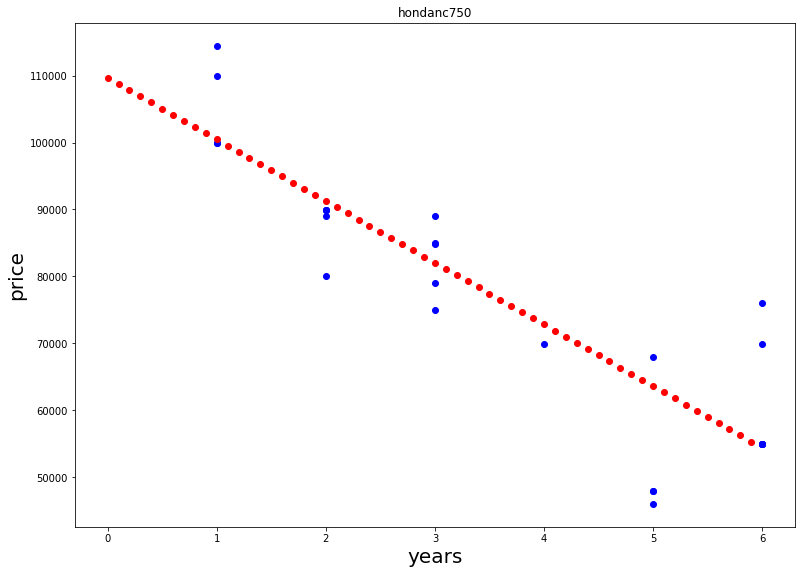

In [188]:
coefs_lr_year = []

rmse_lr_year = []

for idx in set(data_model['id'].values):
    
    reg = linear_model.LinearRegression() 
    
    x = data_model[data_model["id"] == idx]['year_old'].values.reshape(-1, 1)
    
    y = data_model[data_model["id"] == idx]['price'].values
    
    reg.fit(x, y)
    
    coef = reg.coef_
    
    coefs_lr_year.append(coef)
    
    y_pred = reg.predict(x)
    
    error = mean_squared_error(y, y_pred, squared = False)
    
    rmse_lr_year.append(error)
    
    print(idx)
    
    plot_model_linear(x,y,reg, "years", "price", idx)
    

## Linear regression, kilometers and year on price.

In [176]:
rmse_lr2 = []

coefs_lr2 = []

for idx in set(data_model['id'].values):
    
    reg = linear_model.LinearRegression() 
    
    x1 = data_model[data_model["id"] == idx]['kilometers'].values.reshape(-1, 1)
    
    x2 = data_model[data_model["id"] == idx]['year_old'].values.reshape(-1, 1)
    
    x = np.stack((x1, x2), axis = 1).reshape(-1,2)
    
    y = data_model[data_model["id"] == idx]['price'].values
    
    reg.fit(x, y)
    
    y_pred = reg.predict(x)
    
    error = mean_squared_error(y, y_pred, squared = False)
    
    rmse_lr2.append(error)
    
    coefs_lr2.append(reg.coef_)

In [185]:
print("Root Mean Square Error of the ", len(rmse_lr), " linear models created: ", int(np.array(rmse_lr2).mean()))
#The linear regression with 2 variables give the better results.

print("Weighted mean of the Root Mean Square Error (weighted per the number of bikes) :", int(np.average(rmse_lr2, weights=number_of_bikes)))


Root Mean Square Error of the  19  linear models created:  21048
Weighted mean of the Root Mean Square Error (weighted per the number of bikes) : 23790


### Polynomial model, 2 variables

In [178]:
def plot_polynomial_model(x,y):
    #Create the model:
    
    polynomial_features= PolynomialFeatures(degree=2)
    
    x_poly = polynomial_features.fit_transform(x.values.reshape(-1,1))
    
    model = linear_model.LinearRegression() 
    
    model.fit(x_poly, y)
    
    #Fit the line
    x_model = np.arange(0,max(x), 1).reshape(-1, 1)
    
    x_poly_model = polynomial_features.fit_transform(x_model)
    
    y_poly_model_pred = model.predict(x_poly_model)
    
    #Plot
    fig = plt.figure(figsize = (10, 7))
    
    fig.set
    
    ax = fig.add_axes([0,0,1,1])
    
    ax.scatter(x, y, color='b')
    
    ax.scatter(x_model, y_poly_model_pred, color = 'r')
    
    ax.set_xlabel('x', fontsize=25)
    
    ax.set_ylabel('y', fontsize=25)

    #ax.set_title('scatter plot')
    plt.show()

In [179]:
rmse_poly = []

for idx in set(data_model['id'].values):
    
    x1 = data_model[data_model["id"] == idx]['kilometers'].values.reshape(-1, 1)
    
    x2 = data_model[data_model["id"] == idx]['year_old'].values.reshape(-1, 1)
    
    x = np.stack((x1, x2), axis = 1).reshape(-1,2)
    
    y = data_model[data_model["id"] == idx]['price'].values
    
    polynomial_features= PolynomialFeatures(degree=2)
    
    x_poly = polynomial_features.fit_transform(x)
    
    model = linear_model.LinearRegression() 
    
    model.fit(x_poly, y)
    
    y_pred = model.predict(x_poly)
    
    error = mean_squared_error(y, y_pred, squared = False)
    
    rmse_poly.append(error)

In [180]:
print("Root Mean Square Error of the ", len(rmse_poly), " linear models created: ", int(np.array(rmse_poly).mean()))
#The linear regression with 2 variables give the better results.

print("Weighted mean of the Root Mean Square Error (weighted per the number of bikes) :", int(np.average(rmse_poly, weights=number_of_bikes)))
#The mathematical model must overfit. 

Root Mean Square Error of the  19  linear models created:  17945
Weighted mean of the Root Mean Square Error (weighted per the number of bikes) : 20470


# Business question

## By how much the value of a bike is decreasing per 1000km drove?

In [184]:
#Let's use the coef from the linear model kilometer on price. 

In [186]:
km_decote = np.mean(coefs_lr)
print("On average, the value of a bike decreases by ", -int(km_decote * 1000), " Rands for 1000km")

On average, the value of a bike decreases by  1521  Rands for 1000km


## By how much the value of a bike decrease per year?

In [191]:
#Let's use the coef from the linear model year on price
year_decote = np.mean(coefs_lr_year)
print("On average, the value of a bike decreases by ", -int(year_decote), " Rands per year")

On average, the value of a bike decreases by  9258  Rands per year


## What the value of my bike?

In [238]:
def bike_value(make, model, engine_displacement, year_old, km):
    
    id = make.lower() + model.lower() + str(engine_displacement)
    #Create the linear model (year and km) to compute the final price.
    
    reg = linear_model.LinearRegression()
    
    x1 = data_model[data_model["id"] == id]['kilometers'].values.reshape(-1, 1)
    
    x2 = data_model[data_model["id"] == id]['year_old'].values.reshape(-1, 1)
    
    x = np.stack((x1, x2), axis = 1).reshape(-1,2)
    
    y = data_model[data_model["id"] == id]['price'].values
    
    reg.fit(x, y)
    
    my_bike = [[km, year_old]]
    
    prediction = reg.predict(my_bike)
    
    return prediction[0]

In [239]:
def decote_km_value(make, model, engine_displacement):
    
    id = make.lower() + model.lower() + str(engine_displacement)
    #Create the linear model (year and km) to compute the final price.
    
    reg = linear_model.LinearRegression()
    
    x = data_model[data_model["id"] == id]['kilometers'].values.reshape(-1, 1)
    
    y = data_model[data_model["id"] == id]['price'].values
    
    reg.fit(x, y)
    
    decote_km = reg.coef_[0]
    
    return decote_km

In [240]:
def decote_year_value(make, model, engine_displacement):
    
    id = make.lower() + model.lower() + str(engine_displacement)
    #Create the linear model (year and km) to compute the final price.
    
    reg = linear_model.LinearRegression()
    
    x = data_model[data_model["id"] == id]['year_old'].values.reshape(-1, 1)
    
    y = data_model[data_model["id"] == id]['price'].values
    
    reg.fit(x, y)
    
    decote_km = reg.coef_[0]
    
    return decote_km

## Examples

In [255]:
make = "bmw"
model = "f series"
engine_displacement = 800
year_old = 10
km = 90000

bike_value_estimation = bike_value(make, model, engine_displacement, year_old, km)
decote_km_estimation = decote_km_value(make, model, engine_displacement)
decote_year_estimation = decote_year_value(make, model, engine_displacement)

print("You're bike worth: R", int(bike_value_estimate), ".")
print("You should know the value of this model decrease by R", -int(decote_km_estimation * 1000), "after 1000km drove.")
print("The value of this model decrease by R", -int(decote_year_estimation),"every year.")


You're bike worth: R 56939 .
You should know the value of this model decrease by R 580 after 1000km drove.
The value of this model decrease by R 6341 every year.


In [254]:
make = "suzuki"
model = "gsx"
engine_displacement = 1000
year_old = 10
km = 30000

bike_value_estimation = bike_value(make, model, engine_displacement, year_old, km)
decote_km_estimation = decote_km_value(make, model, engine_displacement)
decote_year_estimation = decote_year_value(make, model, engine_displacement)

print("You're bike worth: R", int(bike_value_estimation), ".")
print("You should know the value of this model decrease by R", -int(decote_km_estimation * 1000), "after 1000km drove.")
print("The value of this model decrease by R", -int(decote_year_estimation), "every year.")


You're bike worth: R 101693 .
You should know the value of this model decrease by R 1745 after 1000km drove.
The value of this model decrease by R 8189 every year.


In [256]:

make = "harley-davidson"
model = "sportster"
engine_displacement = 1200
year_old = 2
km = 10000

bike_value_estimation = bike_value(make, model, engine_displacement, year_old, km)
decote_km_estimation = decote_km_value(make, model, engine_displacement)
decote_year_estimation = decote_year_value(make, model, engine_displacement)

print("You're bike worth: R", int(bike_value_estimation), ".")
print("You should know the value of this model decrease by R", -int(decote_km_estimation * 1000), "after 1000km drove.")
print("The value of this model decrease by R", -int(decote_year_estimation), "every year.")


You're bike worth: R 119711 .
You should know the value of this model decrease by R 1631 after 1000km drove.
The value of this model decrease by R 4217 every year.


# Extra: Is building one model per make more effective?

In [316]:
#We don't have a lot of data per model id.
#One of my idea was to group the bike per brand by normalizing the price and the kilometers variables
#I was looking for pattern such as KMT bike lose more value per 1000km than BMW bikes.

In [323]:
#Selection of the data for training the model:
print("Number of bikes before: ", data.shape[0])

data_model_make = data[data['kilometers'].notnull()]
print("Number of bikes after removing the ads which doesn't include the kilometers", data_model_make.shape[0])

data_model_make = data_model_make[data_model_make['year'].notnull()]
print("Number of bikes after removing the ads without year: ", data_model_make.shape[0])

data_model_make = data_model_make[data_model_make['price'] > 0]
print("Number of bikes after removing the ads without price: ", data_model_make.shape[0])

data_model_make = data_model_make[data_model_make['engine_displacement'].notnull()]
print("Number of bikes after removing ads without engine displacement: ", data_model_make.shape[0])

data_model_make = data_model_make[data_model_make['model'] != 'other']
print("Number of bikes after removing the ads without model: ", data_model_make.shape[0])


Number of bikes before:  3747
Number of bikes after removing the ads which doesn't include the kilometers 3289
Number of bikes after removing the ads without year:  3287
Number of bikes after removing the ads without price:  3197
Number of bikes after removing ads without engine displacement:  3197
Number of bikes after removing the ads without model:  2793


In [336]:
#In order to have a good accuracy, samples with a big difference of km are selected.
#This function compute the gap in km between the newest and oldest bike (in term of km) 

def difference_max_min_km(data):
    
    results = data.groupby('id')['kilometers'].apply(np.ptp)
    
    data['difference_max_min_km'] = np.nan
    
    for i in range(data.shape[0]):
        
        data['difference_max_min_km'].iloc[i] = results.loc[data['id'].iloc[i]]

    return data

In [337]:
data_model_make = difference_max_min_km(data_model_make)

In [341]:
km_mini = 30000
data_model_make = data_model_make[data_model_make["difference_max_min_km"] > km_mini]

print("Number of bikes in the sample: ", data_model_make.shape[0])
print("Number of model in the sample: ", data_model_make['id'].nunique())
#print("Number of bike studied: ", )

Number of bikes in the sample:  1438
Number of model in the sample:  81


In [344]:
def normalize_kilometers(data):
    
    data["kilometers_normalized"] = np.nan
    
    for id in data["id"]:
        
        data_filter_id = data[data['id'] == id]
        
        index = data_filter_id.index
        
        data_normalized = preprocessing.normalize([data_filter_id['kilometers']])[0] #Array of dim2.
        
        data.loc[index, ["kilometers_normalized"]] = data_normalized
        
    return data



In [345]:
data_model_make = normalize_kilometers(data_model_make)

In [348]:
def normalize_price(data):
    
    data["price_normalized"] = np.nan
    
    for id in data["id"]:
        
        data_filter_id = data[data['id'] == id]
        
        index = data_filter_id.index
        
        data_normalized = preprocessing.normalize([data_filter_id['price']])[0] #Array of dim2.
        
        data.loc[index, ["price_normalized"]] = data_normalized
        
    return data



In [349]:
data_model_make = normalize_price(data_model_make)

In [265]:
def scaterplot(x,y):
    fig = plt.figure(figsize = (10, 7))
    fig.set
    ax = fig.add_axes([0,0,1,1])
    ax.scatter(x, y, color='b')
    ax.set_xlabel('x', fontsize=25)
    ax.set_ylabel('y', fontsize=25)

    #ax.set_title('scatter plot')
    plt.show()

hondanc750


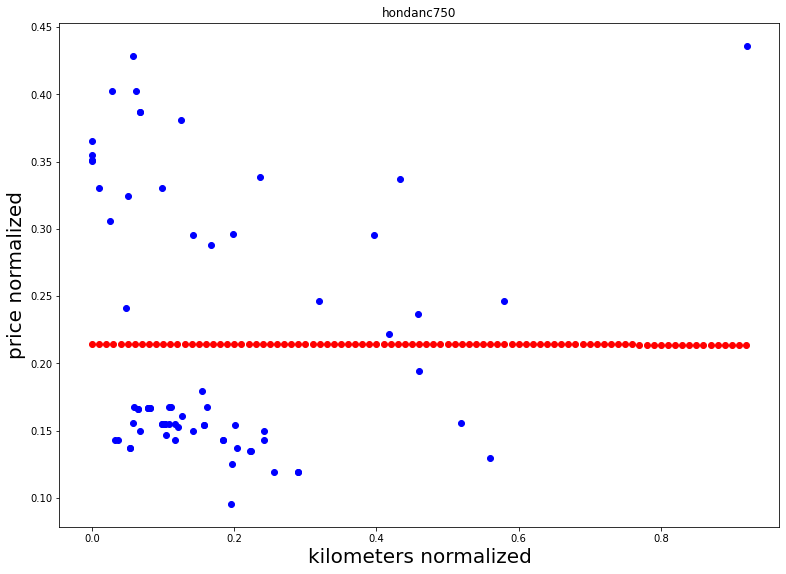

hondanc750


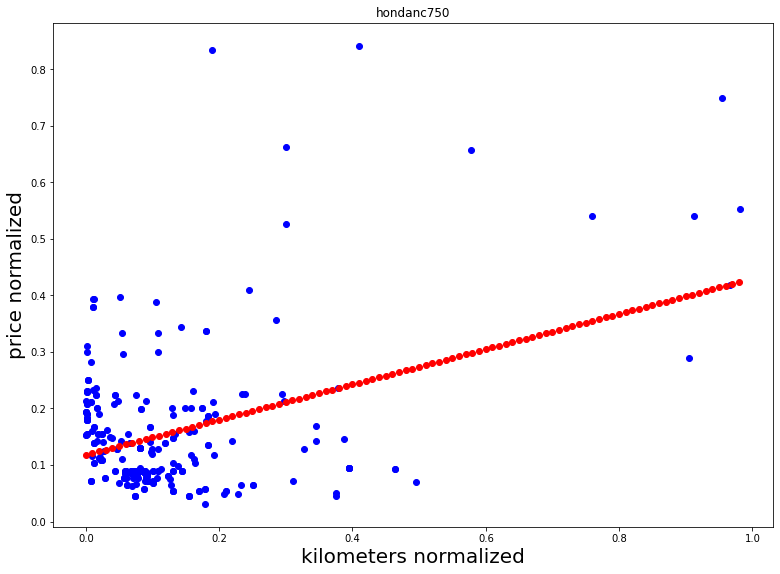

hondanc750


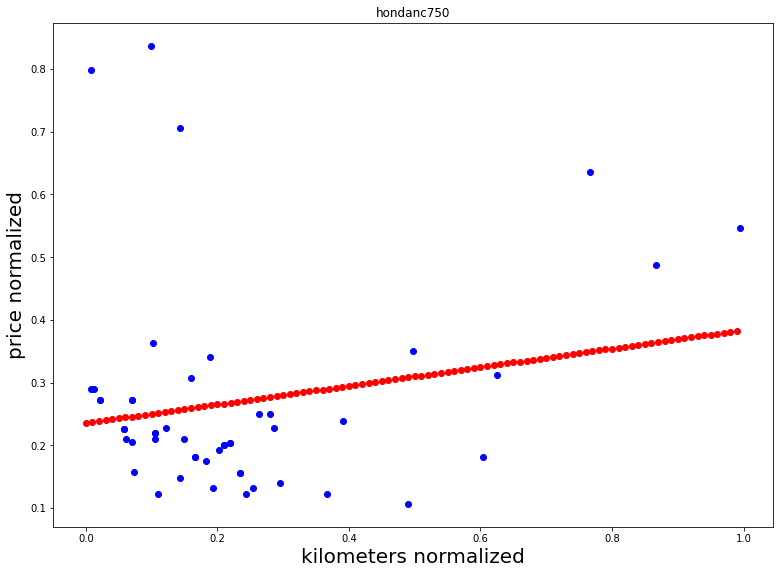

hondanc750


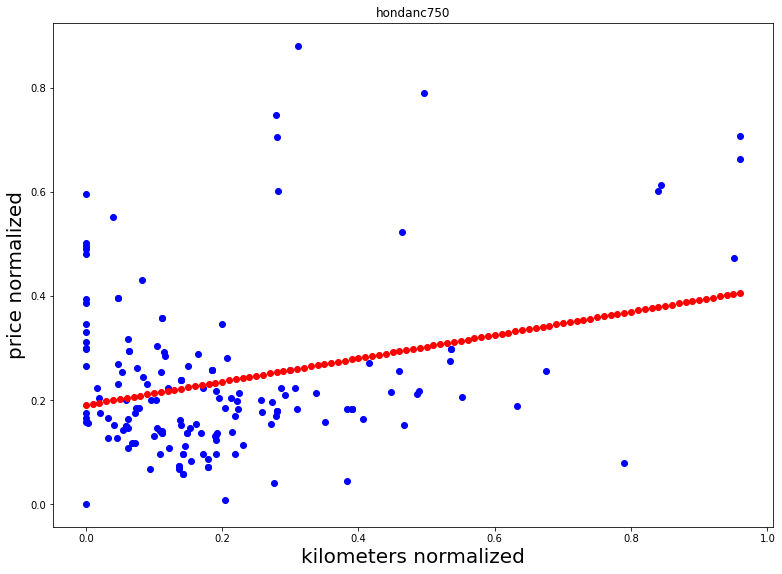

hondanc750


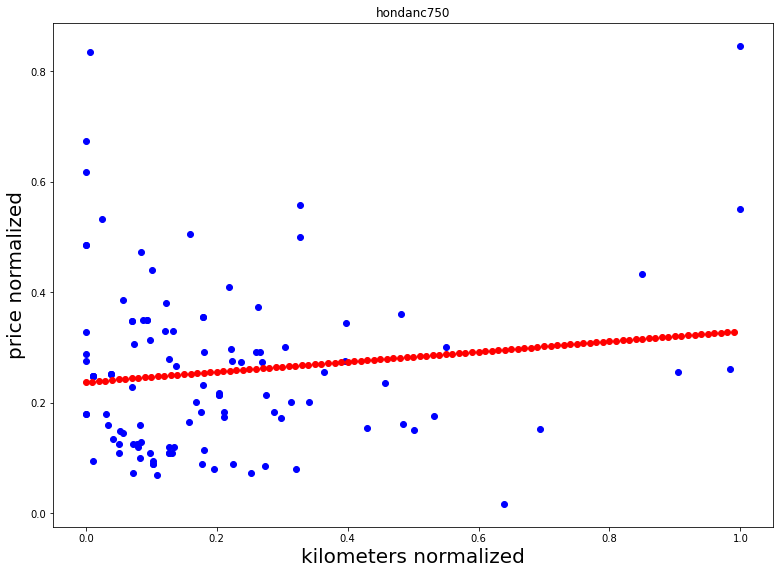

hondanc750


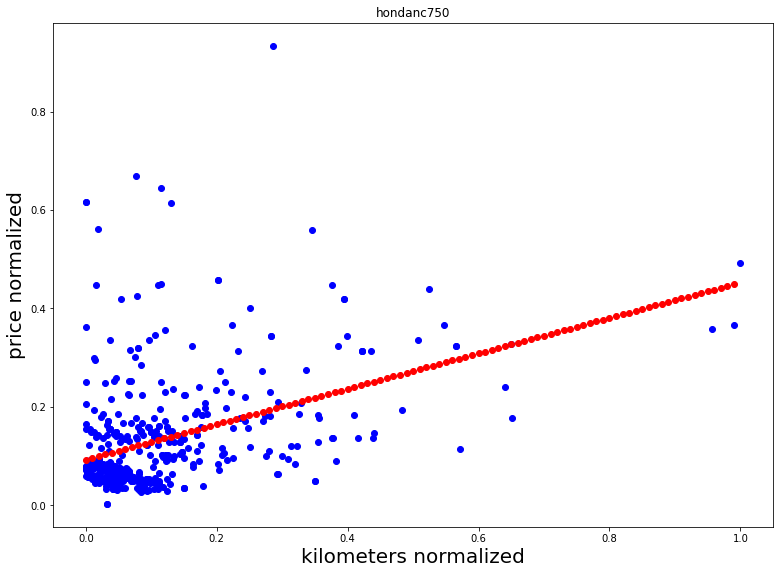

hondanc750


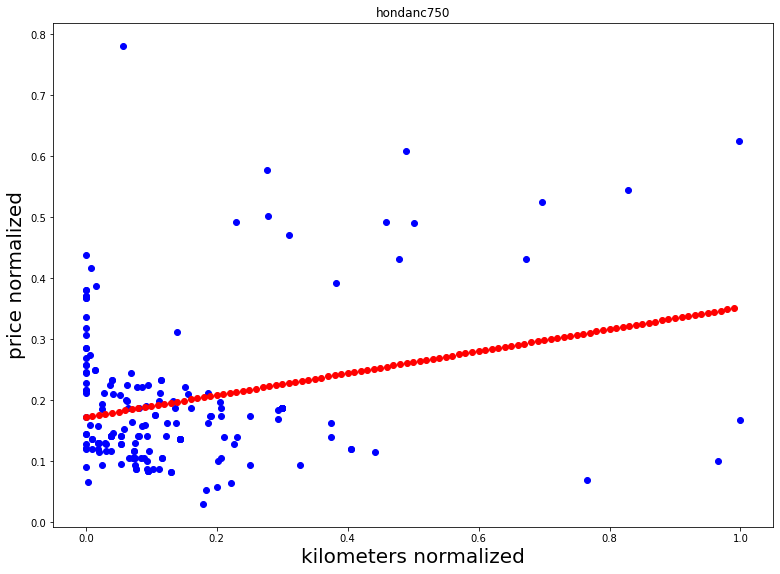

hondanc750


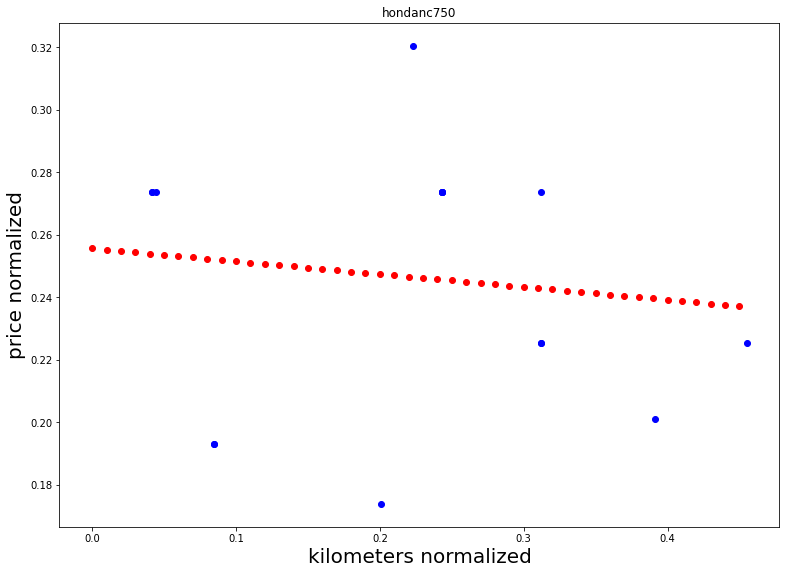

hondanc750


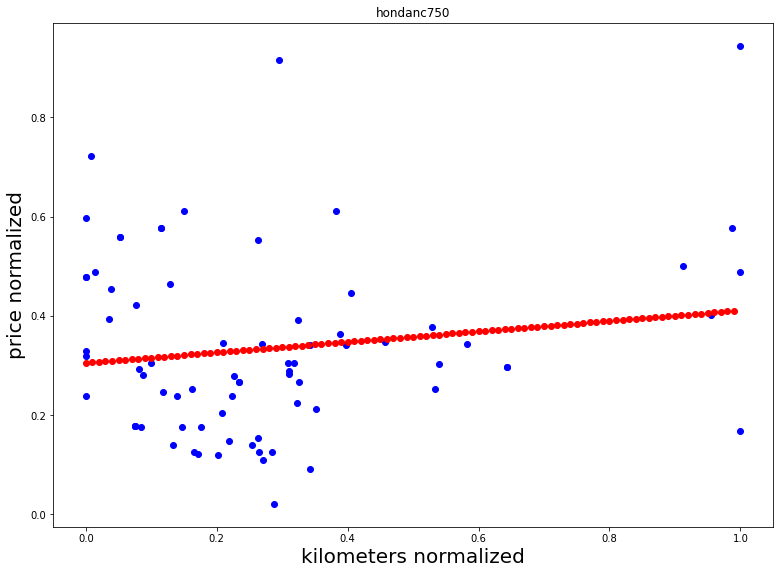

hondanc750


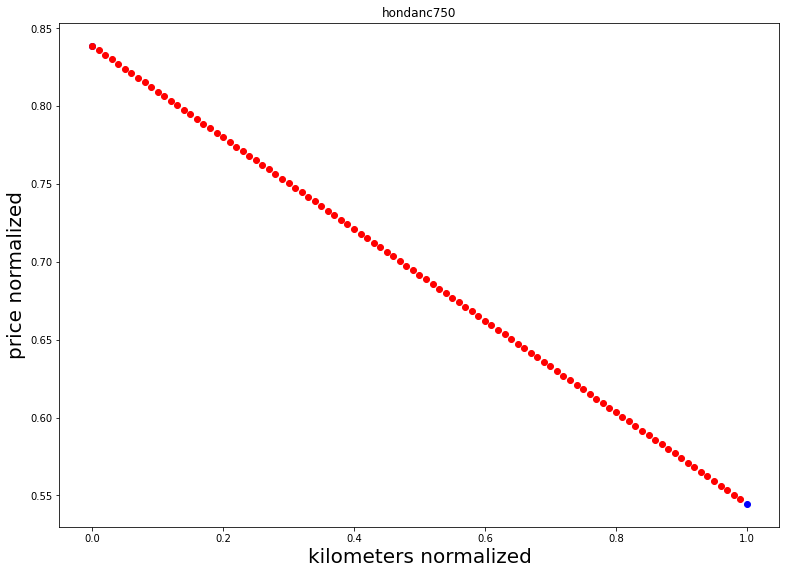

In [356]:
coefs_lr_make = []

rmse_lr_make = []

for make in set(data_model_make['make'].values):
    
    reg = linear_model.LinearRegression() 
    
    x = data_model_make[data_model_make["make"] == make]['kilometers_normalized'].values.reshape(-1, 1)
    
    y = data_model_make[data_model_make["make"] == make]['price_normalized'].values
    
    reg.fit(x, y)
    
    coef = reg.coef_
    
    coefs_lr_year.append(coef)
    
    y_pred = reg.predict(x)
    
    error = mean_squared_error(y, y_pred, squared = False)
    
    rmse_lr_year.append(error)
    
    print(idx)
    
    plot_model_linear(x,y,reg, "kilometers normalized", "price normalized", idx)
    

In [ ]:
#It's doesn't really work as the normalization of the price or the kilometers depends too much on the sample used.
#For instance, let's say the most used bmw f series 800 has done 150 000km. The normalized value will be around 1.
#Now let's say the bmw f series 1200 has done 30 000. The normalized value will also be around 1.
#One can't really use this. 

# Amelioration / new ideas

In [ ]:
#The data is very disparate. The variance of the price is high. More data would be appreciate.

#The data is hard to pre-process. Some extra work should be done to:
#1) correct the name of the model
#2) match better the model name between Gumtree and Autotrader
#3) group some bike together

#Visually, one can see that a linear regression on the km for some bikes work quite well. But for a few bike, it doesn't. Why?

#One could build a lasso or ridge regression. A k fold cross validation could be used to fine tune the parameters and select the best model.

#I don't think deep learning would work here as we don't have a lot of data and we are looking for linear patters.
#But one could create new variables from the description of the bike (ABS? Service history available? Reparation?)


